In [46]:
from MorseComplex import *
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import topopy
import pdir
import time

In [13]:
def show_image(image):
    plt.figure(num=None, dpi=200)
    img = plt.imshow(image, cmap=plt.cm.Greys_r, norm=colors.LogNorm(vmin=image.min(), vmax=image.max()),)
    plt.colorbar(img)

# Investigating Mandatory Critical Fields

In [4]:
class Path(list):
    def add(self, item):
        self.append(item)
        

def plot_colorline(x,y,c):
    c = cm.Greys((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return        

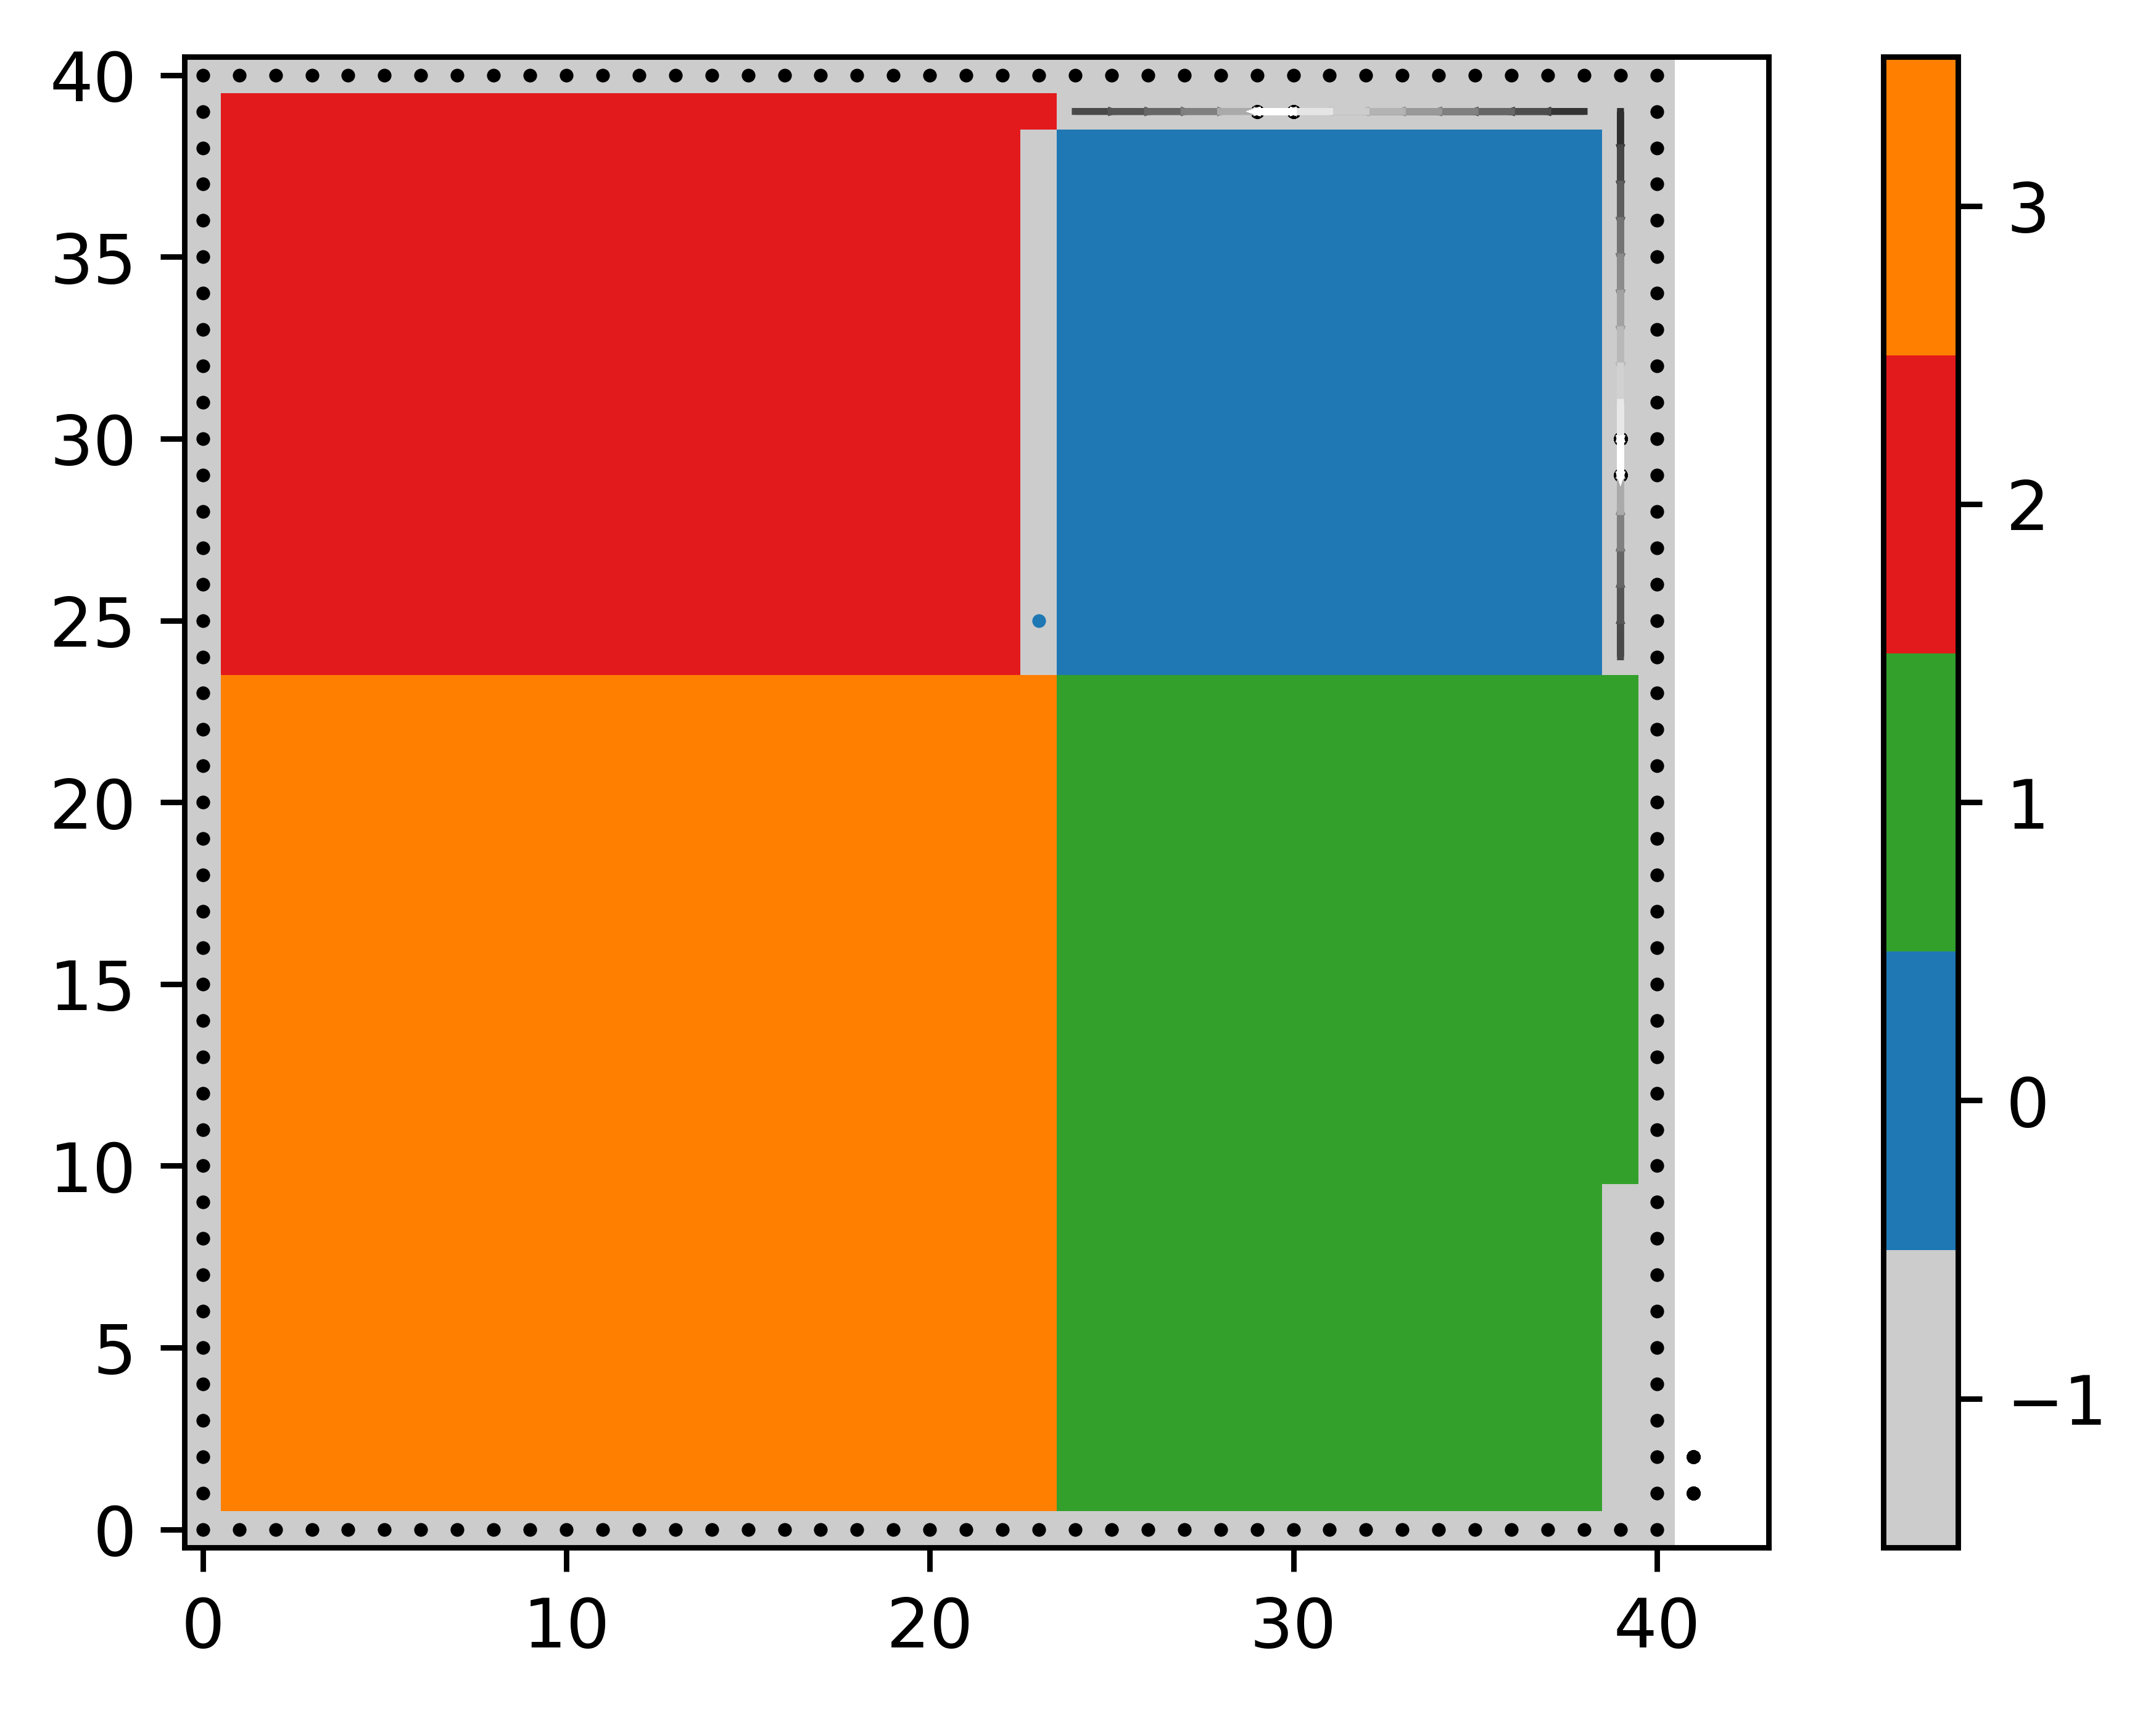

In [24]:
xComponent = scipy.io.loadmat("data/xComponent")["discreteGradProbX"]
yComponent = scipy.io.loadmat("data/yComponent")["discreteGradProbY"]
mandatoryMaxima = scipy.io.loadmat("data/mandatoryMax")["mandatoryMax"]

mc = MorseComplex2D(xComponent, yComponent, mandatoryMaxima)

flow = mc.maxFlow
# print(np.unique(flow))
flow[np.where(flow < 0)] = -1
uniqueCount = len(np.unique(flow))

colorList = [
    "#cccccc",
    "#1f78b4",
    "#33a02c",
    "#e31a1c",
    "#ff7f00",
    "#6a3d9a",
    "#b15928",
    "#a6cee3",
    "#b2df8a",
    "#fb9a99",
    "#fdbf6f",
    "#cab2d6",
    "#ffff99",
]

########################################################################

cmap = colors.ListedColormap(colorList[:uniqueCount])
bounds = np.unique(flow) - 0.5
bounds = bounds.tolist()
bounds.append(bounds[-1]+1)
plt.figure(dpi=800)
img = plt.imshow(flow, cmap=cmap, interpolation="nearest", origin="lower")
plt.colorbar(img, cmap=cmap, ticks=np.unique(flow), boundaries=bounds)

########################################################################

# colorCycle = itertools.cycle(colorList)
# colorMap = {}

# ids = {}
# for i in np.unique(mc.maxFlow):
#     colorMap[i] = next(colorCycle)
#     ids[i] = []
#     for row, vals in enumerate(mc.maxFlow):
#         for col, val in enumerate(vals):
#             if val == i:
#                 ids[i].append([col, row])

# for key, values in ids.items():
#     positions = np.array(values)
#     plt.scatter(positions[:, 0], positions[:, 1], c=colorMap[key])

flow = mc.maxFlow
touched = set()
for j, row in enumerate(flow):
    for i, col in enumerate(row):
        if col == -1:
            touched = Path()
            destination = mc.trace(i, j, touched)
            xs = []
            ys = []
            color = 0
            x = destination // flow.shape[1]
            y = destination % flow.shape[1]
            plt.scatter([x], [y], color="0.0", s = 1)

            for idx in touched:
                xs.append(idx // flow.shape[1])
                ys.append(idx % flow.shape[1])
                color += 1. / len(touched)
                if len(xs) > 1:
                    plt.arrow(xs[-2], ys[-2], xs[-1]-xs[-2], ys[-1]-ys[-2], color=str(color))


plt.scatter([23], [25], s=1)
plt.show()

In [5]:
i=23
j=25
touched = Path()
destination = mc.trace(i, j, touched)
print(destination, i*41+j, touched)

1682 968 [968]


In [6]:
1682 // 41, 1682 % 41

(41, 1)

In [7]:
mc.uf.Find(968) - 1680

2

Possibly a bug in what I am doing here related to the offset I add to ensure no collisions with real indices.

# Counting Consistency of Points

In [14]:
ground_truth = scipy.io.loadmat("data/groundtruth1.mat")['gt']
uncertain_realizations = scipy.io.loadmat("data/uncertain1.mat")['noisyEnsemble']

In [15]:
def massage_data(grid):
    X = []
    Y = []
    for row, vals  in enumerate(grid):
        for col, val in enumerate(vals):
            X.append([col, row])
            Y.append(val)
    return np.array(X, dtype=np.float64), np.array(Y, dtype=np.float64)

In [16]:
def alpha_blend(src, dest):
    out_image = np.zeros(dest.shape)
    out_image[:, :, 3] = src[:, :, 3] + dest[:, :, 3]*(1 - src[:, :, 3])
    out_image[:, :, :-1] = src[:,:,:-1]*src[:,:3] + dest[:,:,:-1]*dest[:,:,3]*(1 - src[:, :, 3])
    out_image[:, :, :-1] /= out_image[:, :, 3]
    
def overlay_alpha_image_lazy(background_rgb, overlay_rgba, alpha):
    # cf https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    # If the destination background is opaque, then
    #   out_rgb = overlay_rgb * overlay_alpha + background_rgb * (1 - overlay_alpha)
    overlay_alpha = overlay_rgba[: , : , 3].astype(np.float) / 255. * alpha
    overlay_alpha_3 = np.dstack((overlay_alpha, overlay_alpha, overlay_alpha))
    overlay_rgb = overlay_rgba[: , : , : 3].astype(np.float)
    background_rgb_f = background_rgb.astype(np.float)
    out_rgb = overlay_rgb * overlay_alpha_3 + background_rgb_f * (1. - overlay_alpha_3)
    out_rgb = out_rgb.astype(np.uint8)
    return out_rgb

def overlay_alpha_image_precise(background_rgb, overlay_rgba, alpha, gamma_factor=2.2):
    """
    cf minute physics brilliant clip "Computer color is broken" : https://www.youtube.com/watch?v=LKnqECcg6Gw
    the RGB values are gamma-corrected by the sensor (in order to keep accuracy for lower luminancy),
    we need to undo this before averaging.
    """
    overlay_alpha = overlay_rgba[: , : , 3].astype(np.float) / 255. * alpha
    overlay_alpha_3 = np.dstack((overlay_alpha, overlay_alpha, overlay_alpha))

    overlay_rgb_squared = np.float_power(overlay_rgba[: , : , : 3].astype(np.float), gamma_factor)
    background_rgb_squared = np.float_power( background_rgb.astype(np.float), gamma_factor)
    out_rgb_squared = overlay_rgb_squared * overlay_alpha_3 + background_rgb_squared * (1. - overlay_alpha_3)
    out_rgb = np.float_power(out_rgb_squared, 1. / gamma_factor)
    out_rgb = out_rgb.astype(np.uint8)
    return out_rgb


In [17]:
def plot_realization(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    tmc = topopy.MorseComplex(graph='beta skeleton',
                              gradient='steepest',
                              normalization='feature',
                              connect=True)
    tmc.build(X, Y)

    partitions = tmc.get_partitions()
    keys = partitions.keys()

    keyMap = {}
    for i,k in enumerate(keys):
        keyMap[k] = i

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    uniqueCount = len(keys)
    cmap = colors.ListedColormap(colorList[:uniqueCount])
    bounds = np.array([keyMap[k] for k in keys]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)
    plt.figure(dpi=800)

    color_mesh = np.zeros((w, h))
    for key, indices in tmc.get_partitions().items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    img = plt.imshow(color_mesh, cmap=cmap, interpolation="nearest", origin="lower")
    plt.colorbar(img, cmap=cmap, ticks=np.unique(flow), boundaries=bounds)
    plt.contour(grid, cmap=cm.Greys)

In [18]:
def count_persistence(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    tmc = topopy.MorseComplex(graph='beta skeleton',
                              gradient='steepest',
                              normalization='feature',
                              max_neighbors=10,
                              connect=True)
    tmc.build(X, Y)

    partitions = tmc.get_partitions()
    sorted_hierarchy = sorted([(p, k, x) for k, (p, x, s) in tmc.merge_sequence.items()])
    
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        field[v] = k
    
    counts = np.zeros(Y.shape)
    weighted_counts = np.zeros(Y.shape)
    last_persistence = 0
    for persistence, dying_index, surviving_index in sorted_hierarchy:
        next_field = np.array(field)
        next_field[np.where(next_field == dying_index)] = surviving_index
        
        counts[np.where(field == next_field)] += 1
        weighted_counts[np.where(field == next_field)] += (persistence-last_persistence)
        field = next_field
        last_persistence = persistence

    return counts.reshape(grid.shape), weighted_counts.reshape(grid.shape)

In [19]:
def assignments(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    tmc = topopy.MorseComplex(graph='beta skeleton',
                              gradient='steepest',
                              normalization='feature',
                              max_neighbors=10,
                              connect=True)
    tmc.build(X, Y)

    correct_p = 0
    for p in tmc.persistences: 
        if len(tmc.get_partitions(p).keys()) == 4:
            correct_p = p
            partitions = tmc.get_partitions(p)
            
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        
        x = k // 41
        y = k % 41
        field[v] = 0
        if x > 23 and y > 23:
            field[v] = 3
        elif y > 23:
            field[v] = 2
        elif x > 23:
            field[v] = 1
    
    return field.reshape(grid.shape), correct_p

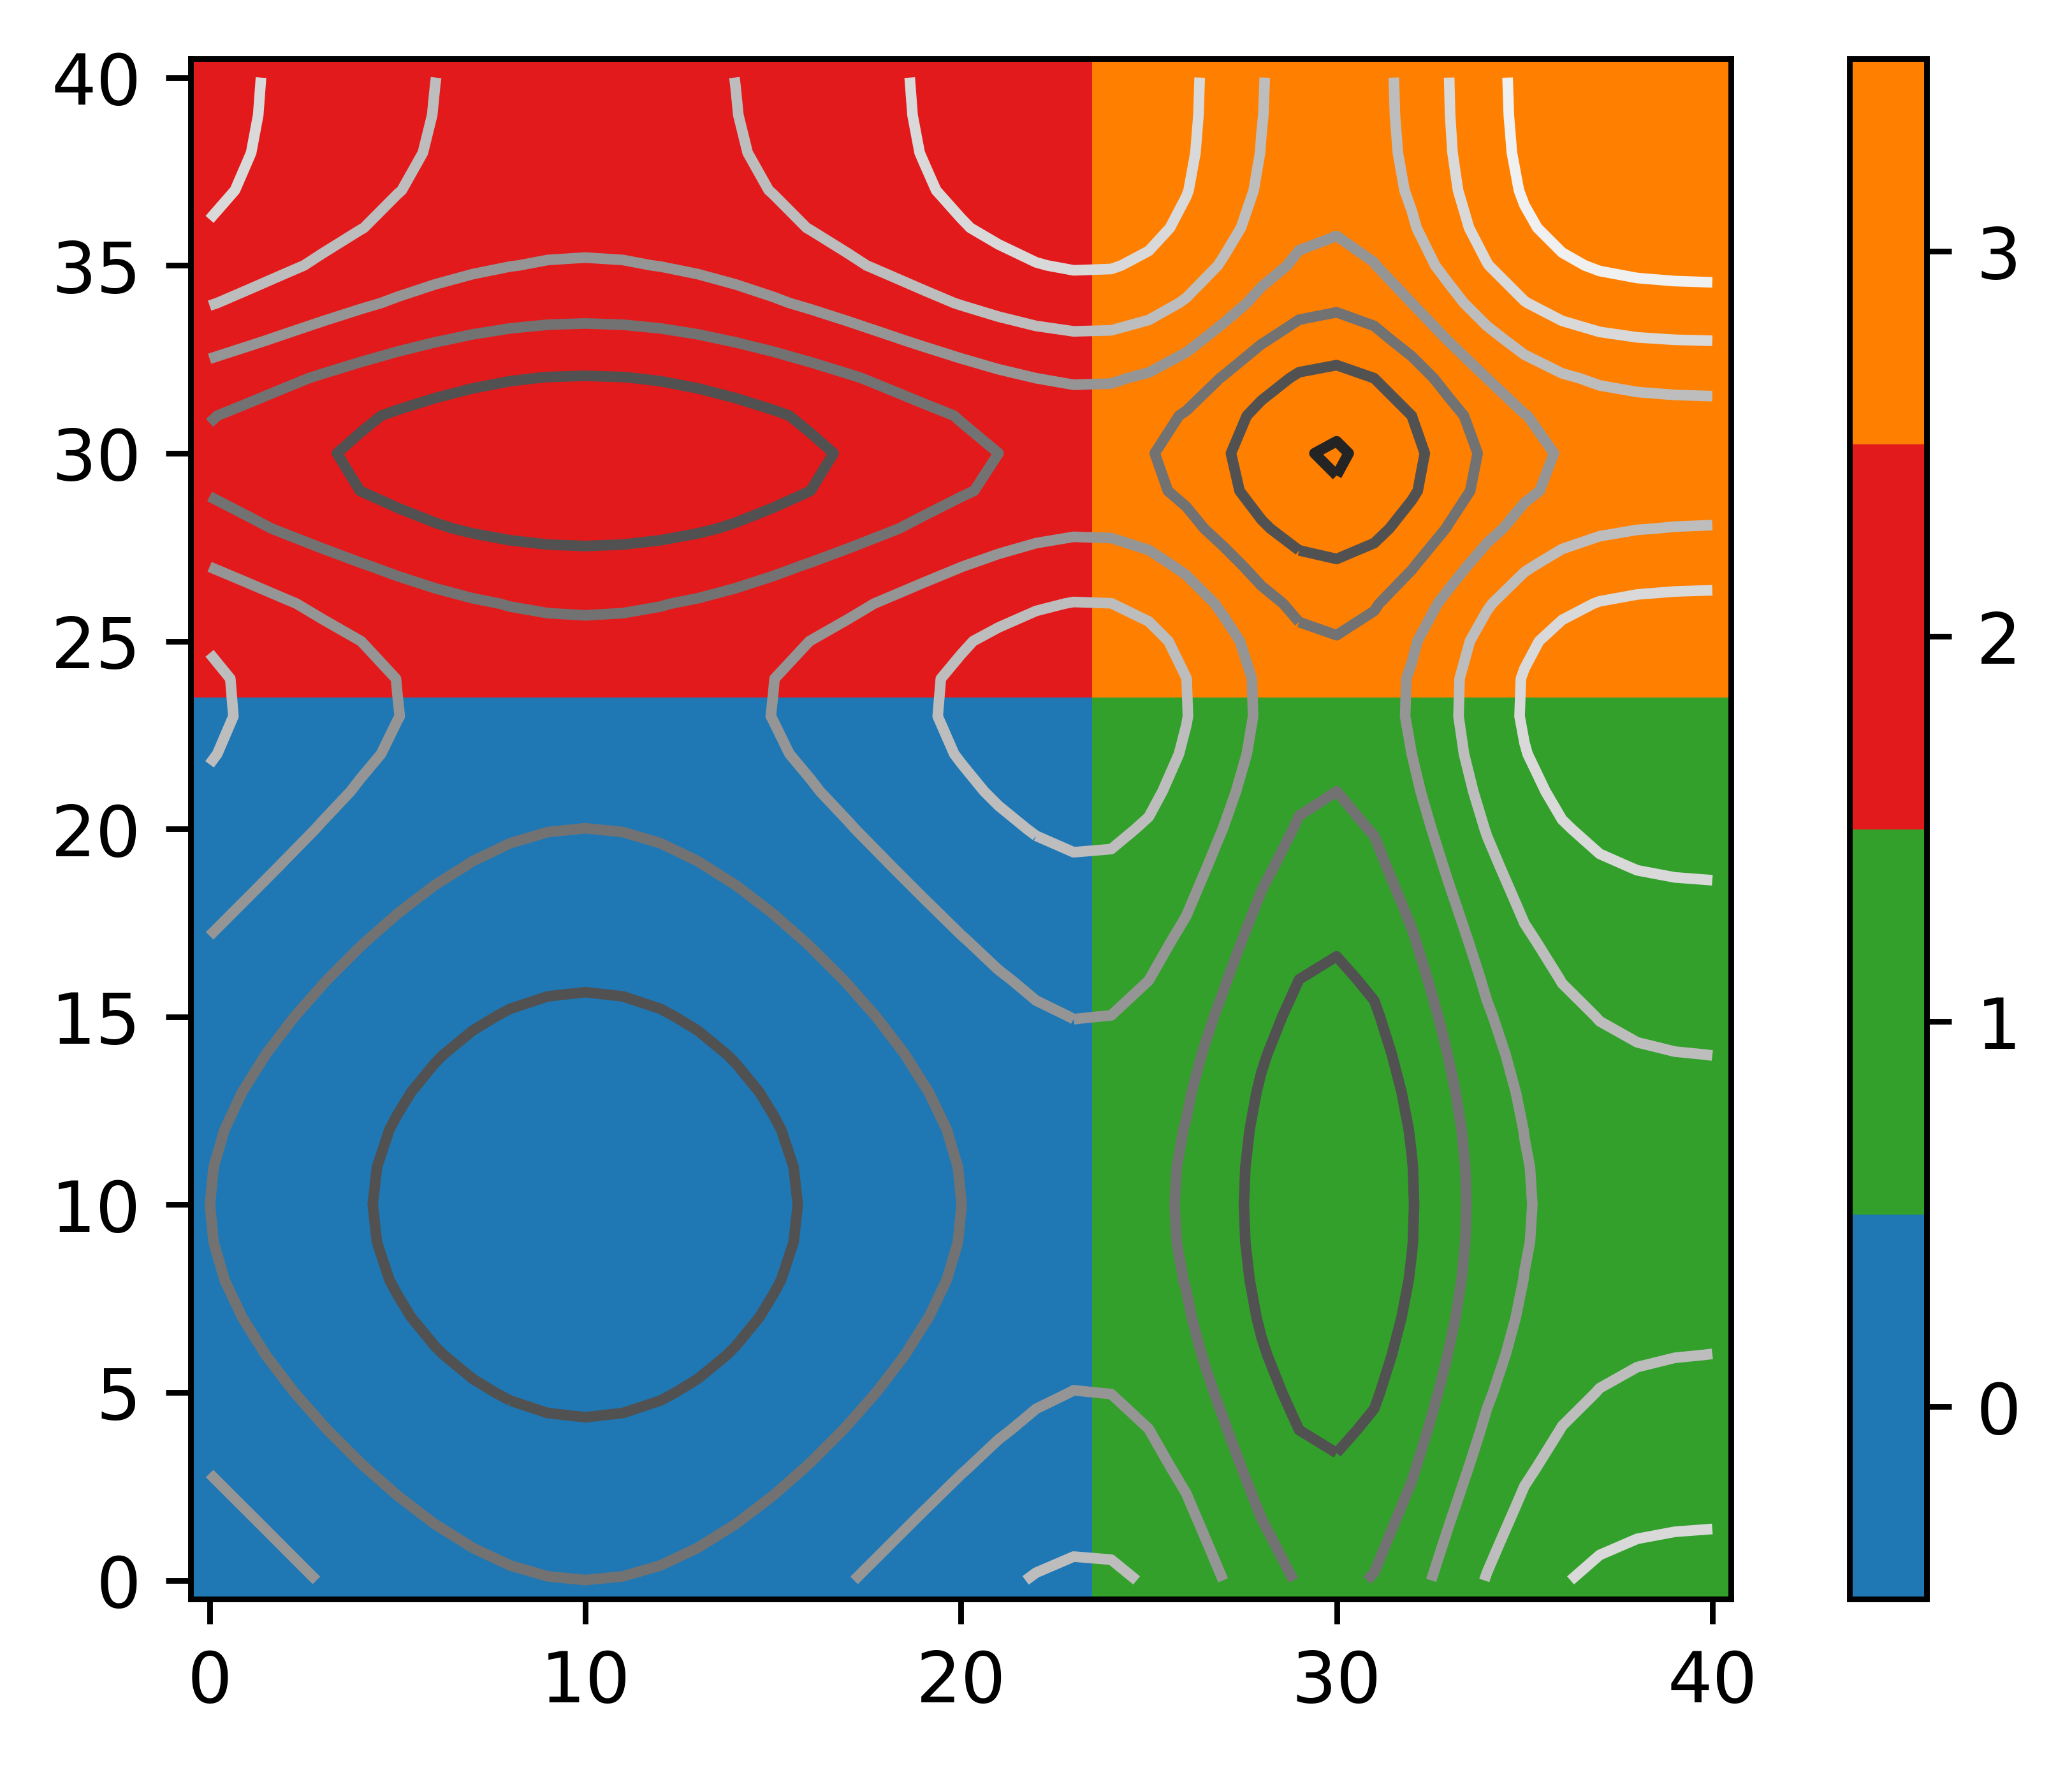

In [23]:
plot_realization(ground_truth)

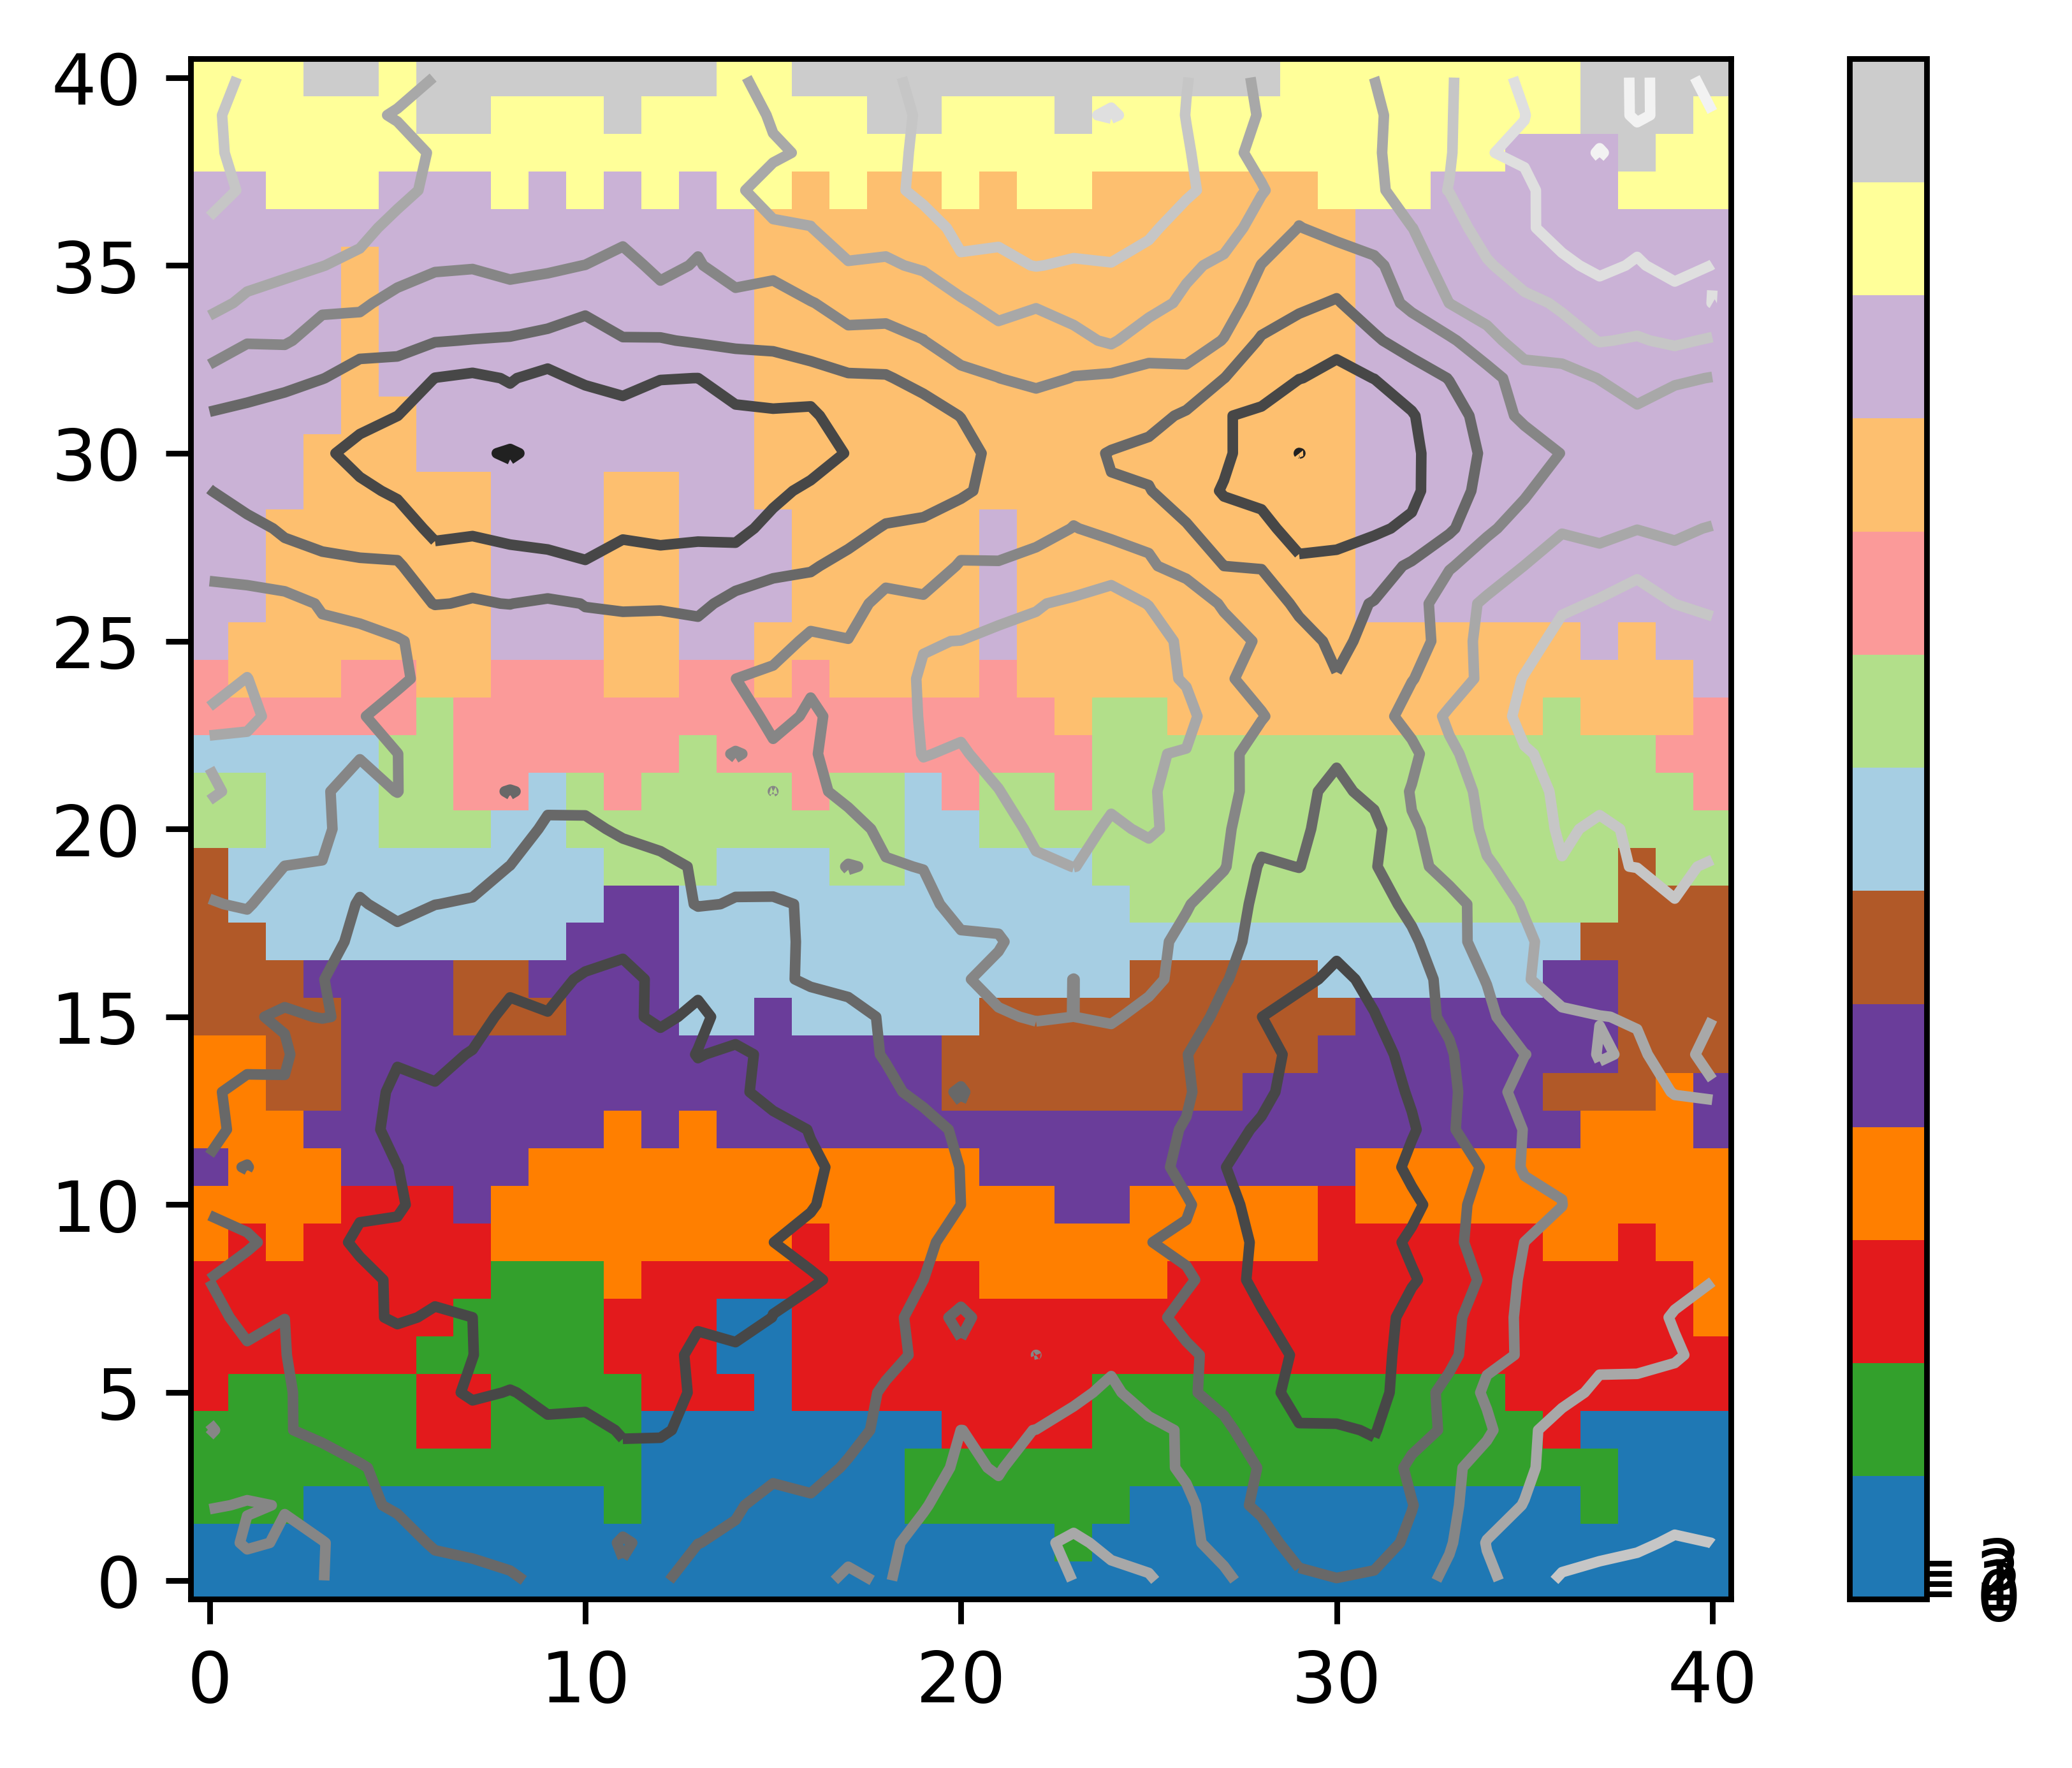

In [25]:
plot_realization(uncertain_realizations[:,:,0])

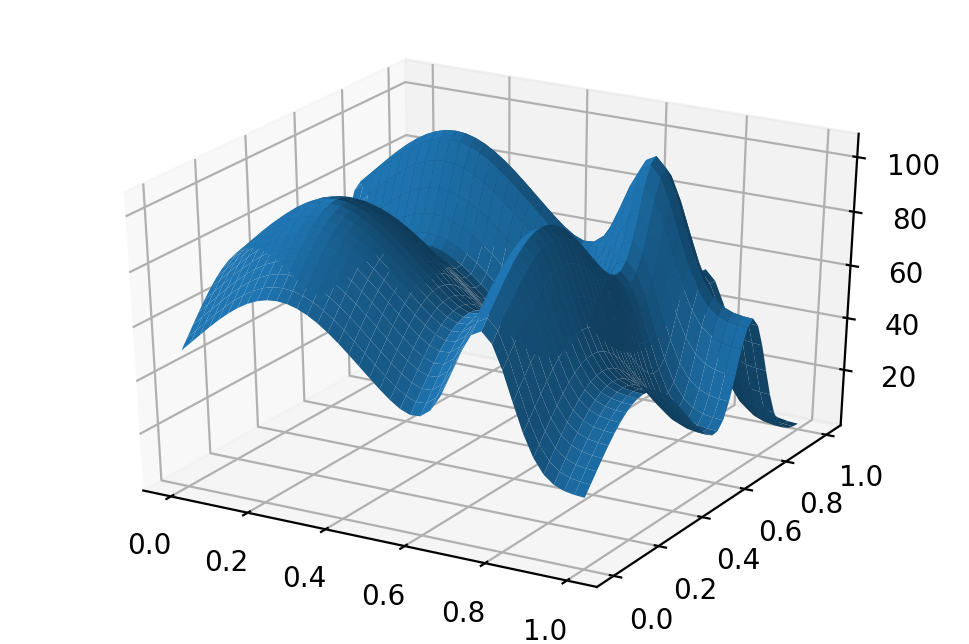

In [26]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
xi = np.linspace(0, 1, 41)
X, Y = np.meshgrid(xi, xi)
img = ax.plot_surface(X=X, Y=Y, Z=ground_truth)

In [27]:
all_counts = np.zeros(uncertain_realizations[:,:,0].shape)
all_weighted_counts = np.zeros(uncertain_realizations[:,:,0].shape)
for i in range(uncertain_realizations.shape[2]):
# for i in range(1):
    counts, weighted_counts = count_persistence(uncertain_realizations[:,:,i])
    all_counts += counts
    all_weighted_counts += weighted_counts

7648.0


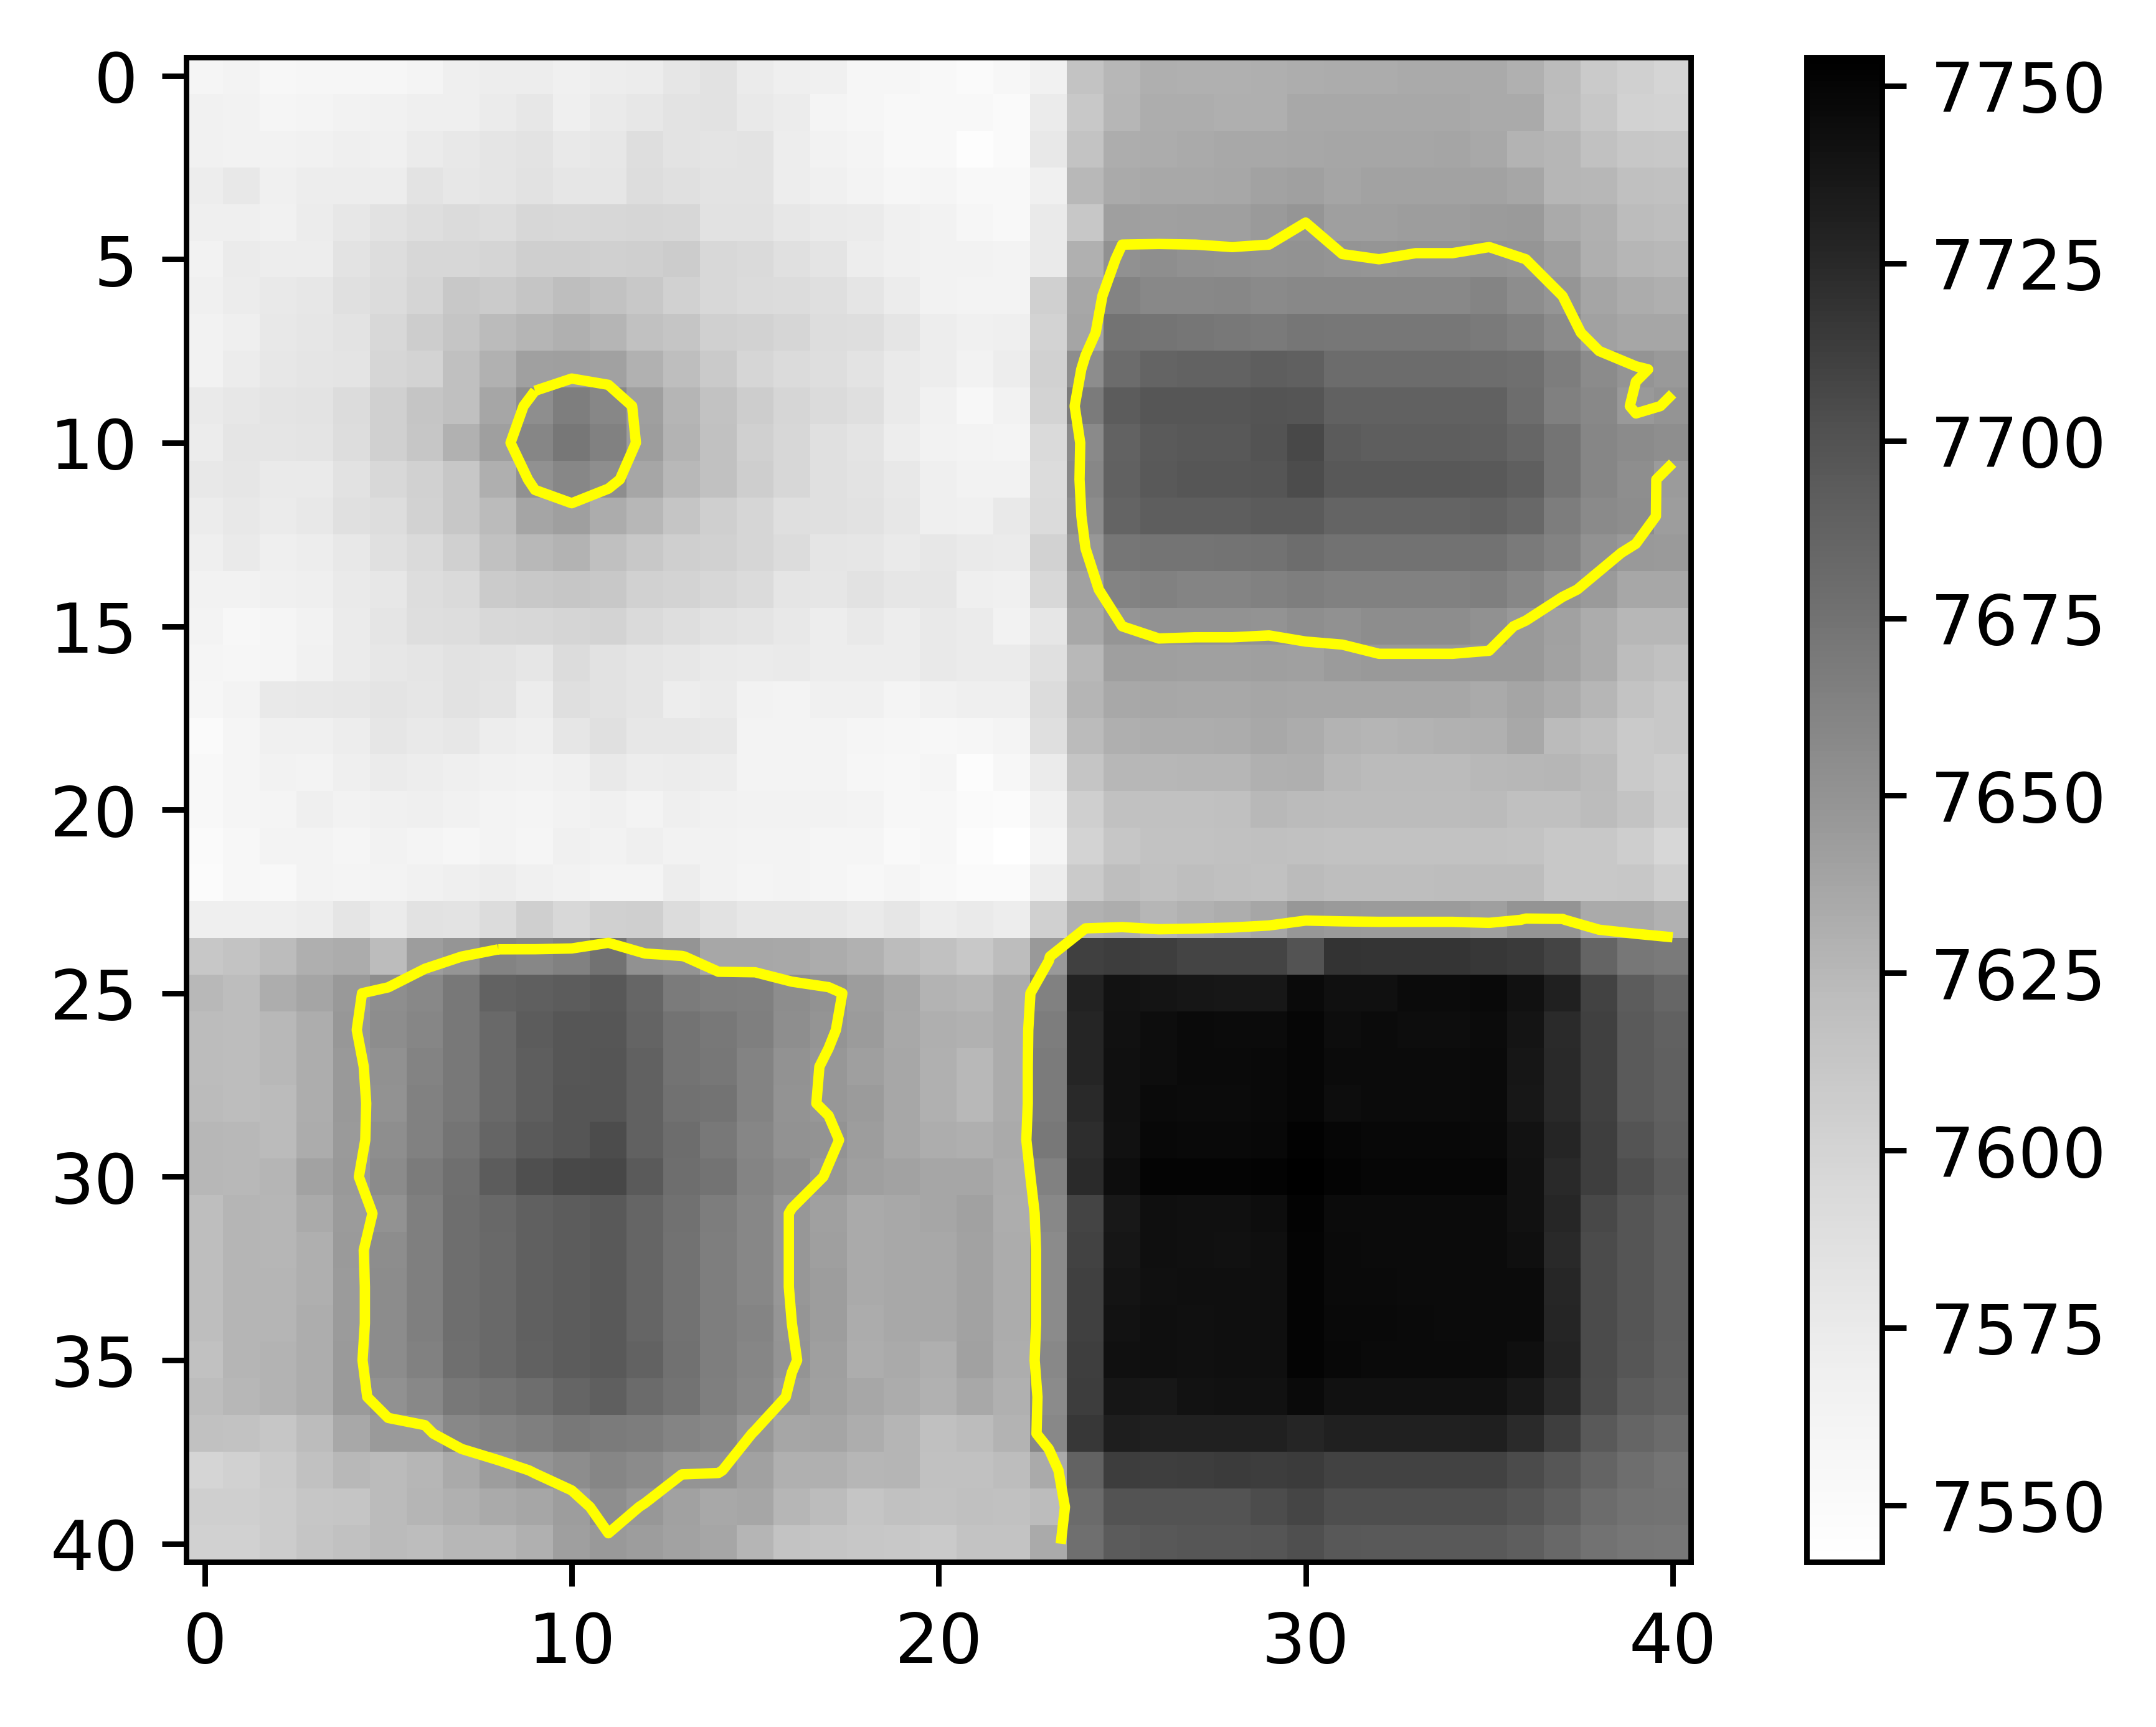

In [28]:
plt.figure(dpi=800)
img = plt.imshow(all_counts, cmap=cm.Greys)
plt.colorbar(img)
k = (np.max(all_counts) + np.min(all_counts)) / 2.
print(k)
plt.contour(all_counts, levels=[k], colors='#FFFF00')

In [29]:
counts = np.zeros(uncertain_realizations[:,:,0].shape)
weighted_counts = np.zeros(uncertain_realizations[:,:,0].shape)
# for i in range(uncertain_realizations.shape[2]):
for i in range(1):
    counts, weighted_counts = count_persistence(uncertain_realizations[:,:,i])
    all_counts += counts
    all_weighted_counts += weighted_counts

5143.394295099999


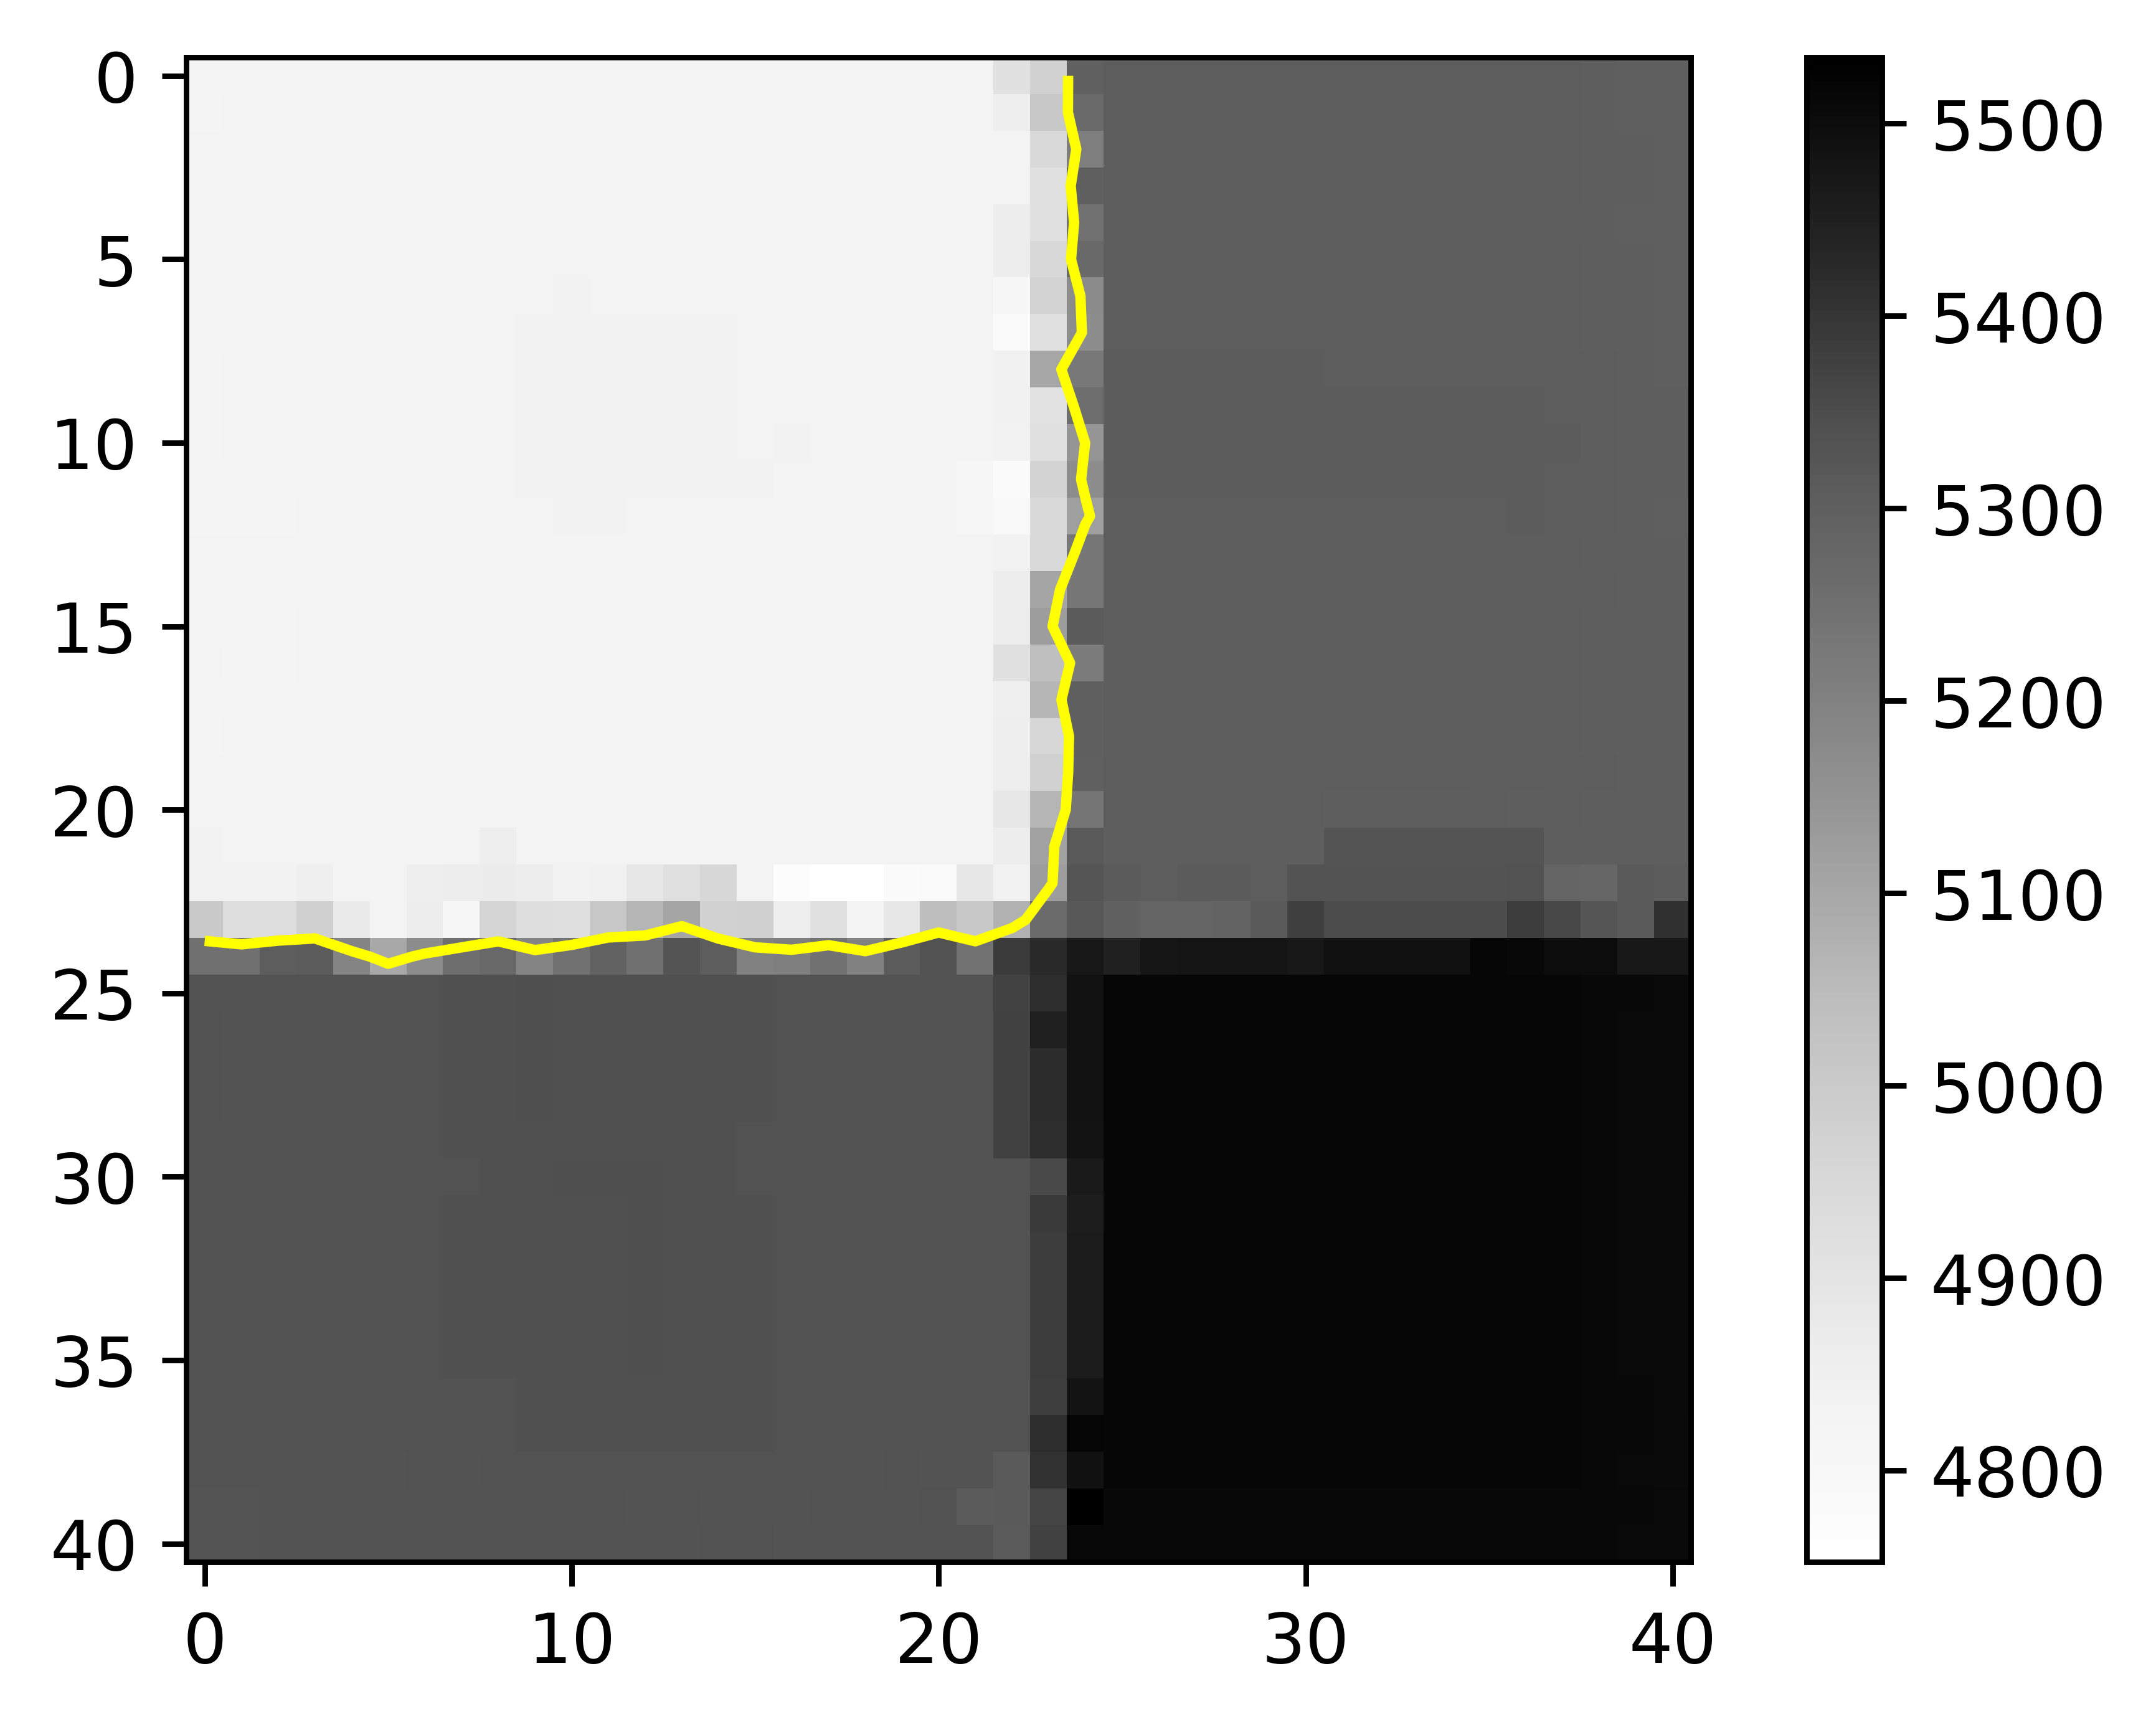

In [30]:
plt.figure(dpi=800)
img2 = plt.imshow(all_weighted_counts, cmap=cm.Greys)
plt.colorbar(img2)
k = (np.max(all_weighted_counts) + np.min(all_weighted_counts)) / 2.
print(k)
plt.contour(all_weighted_counts, levels=[k], colors='#FFFF00')

/Users/maljovec/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


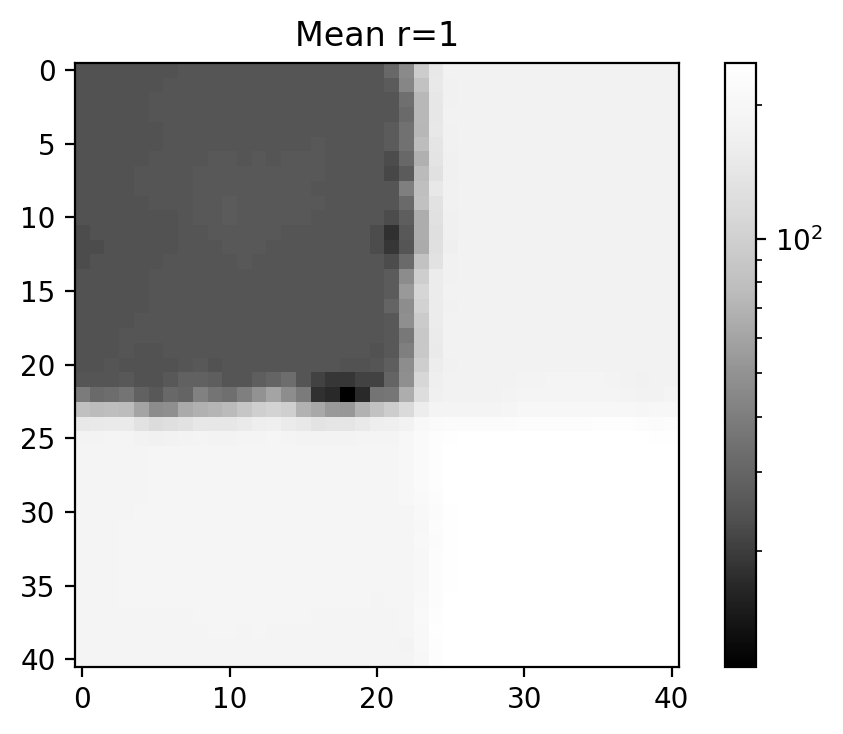

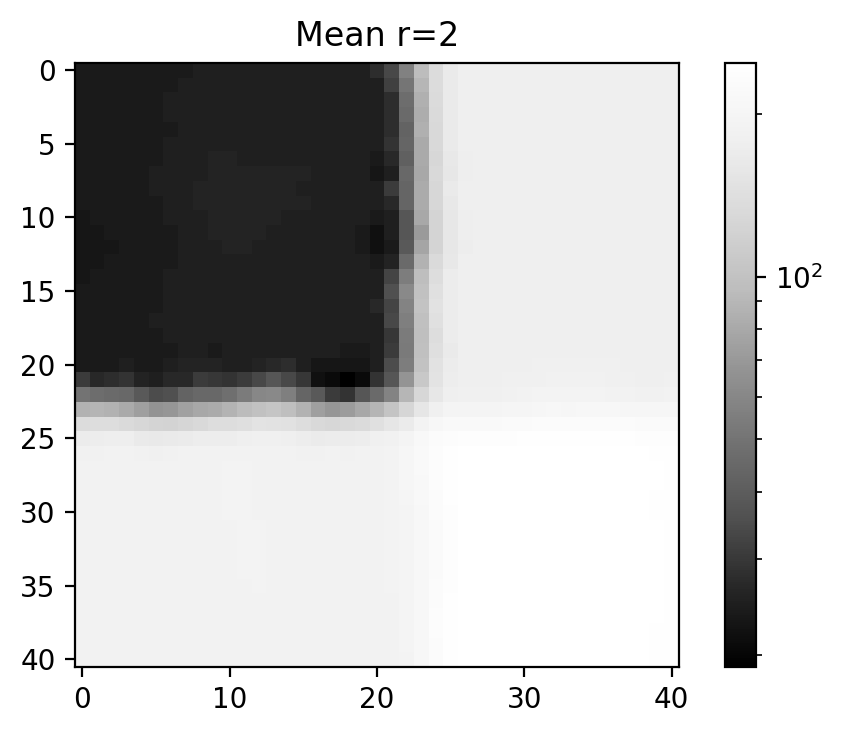

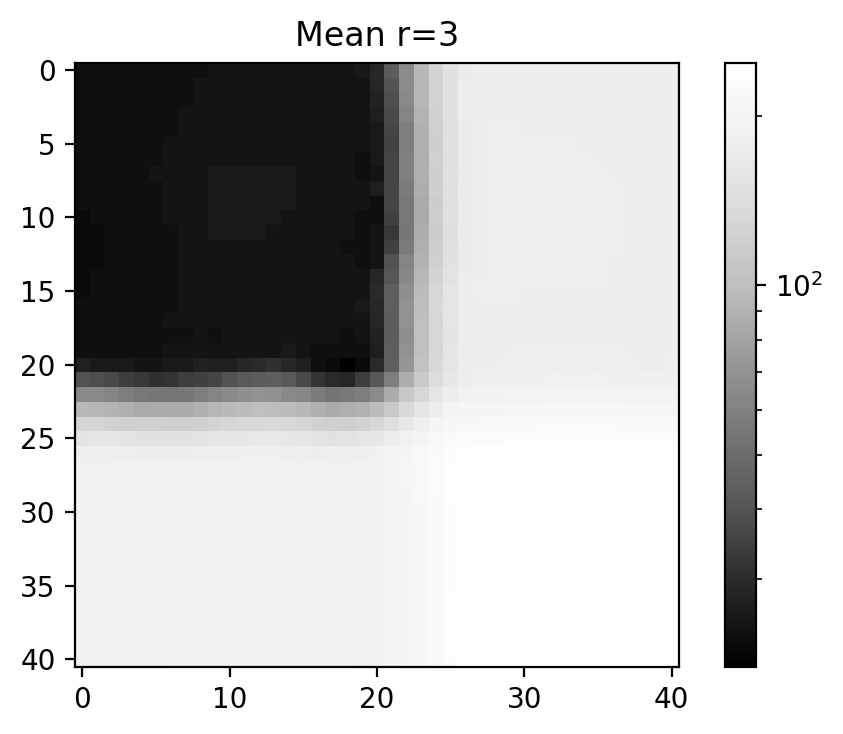

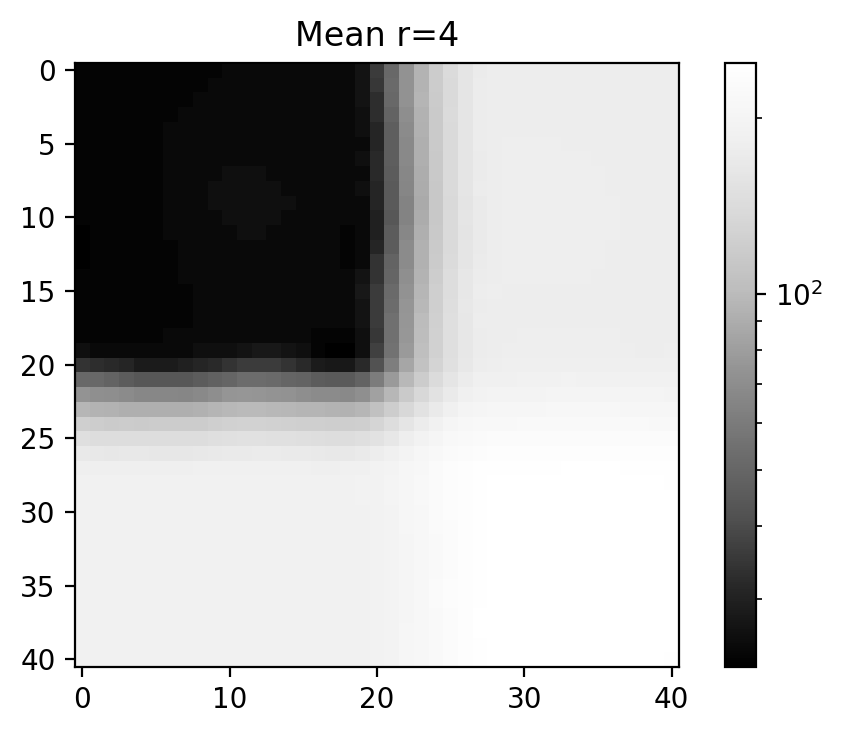

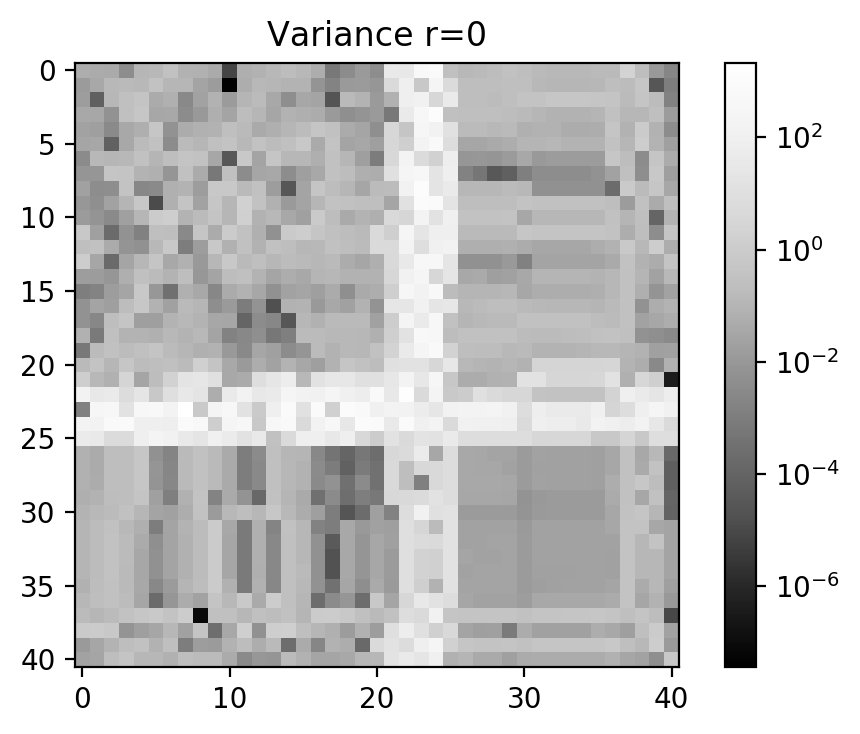

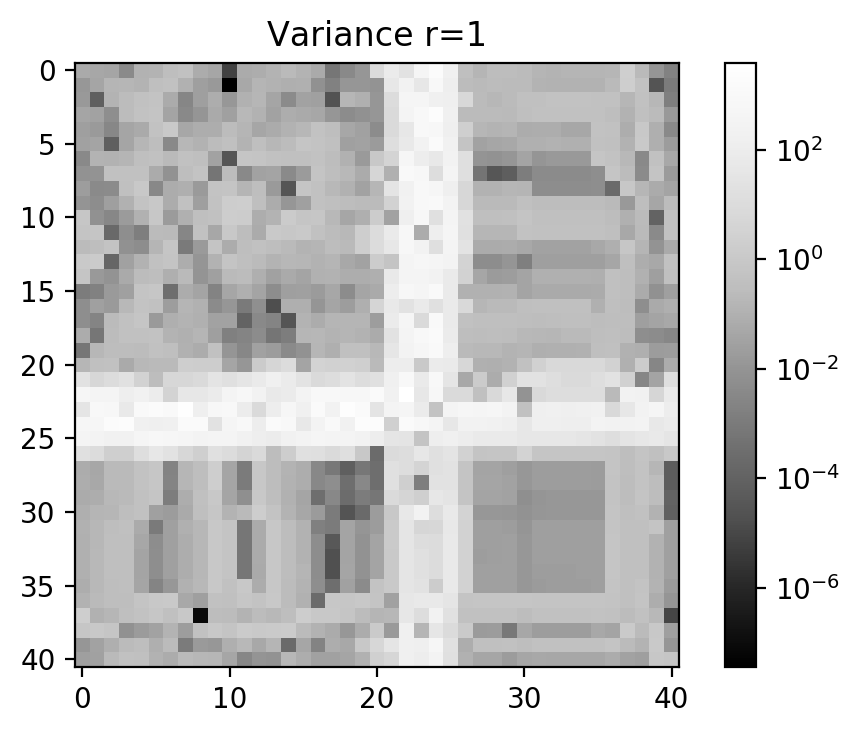

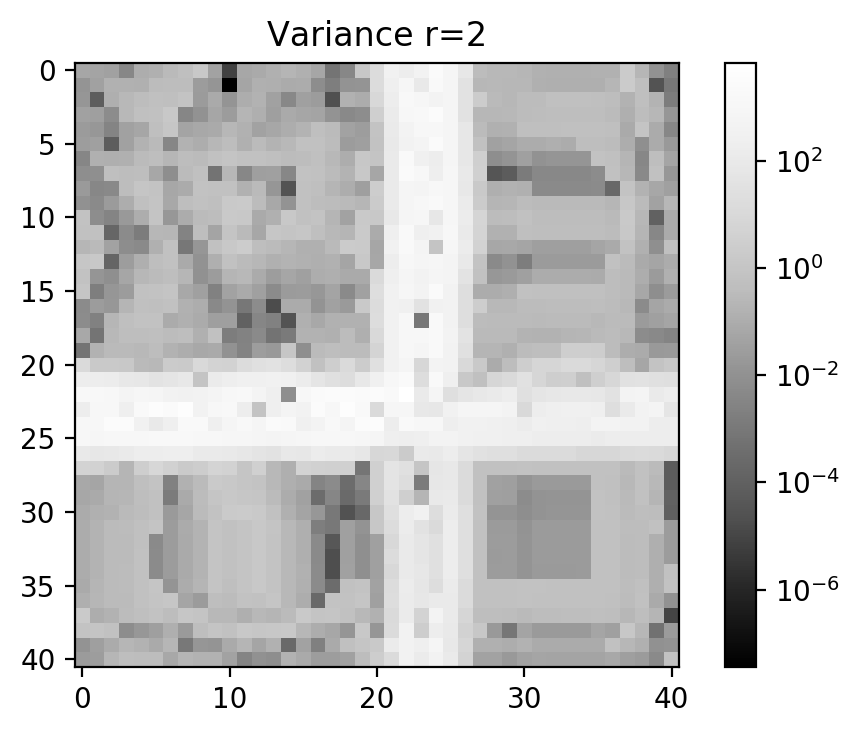

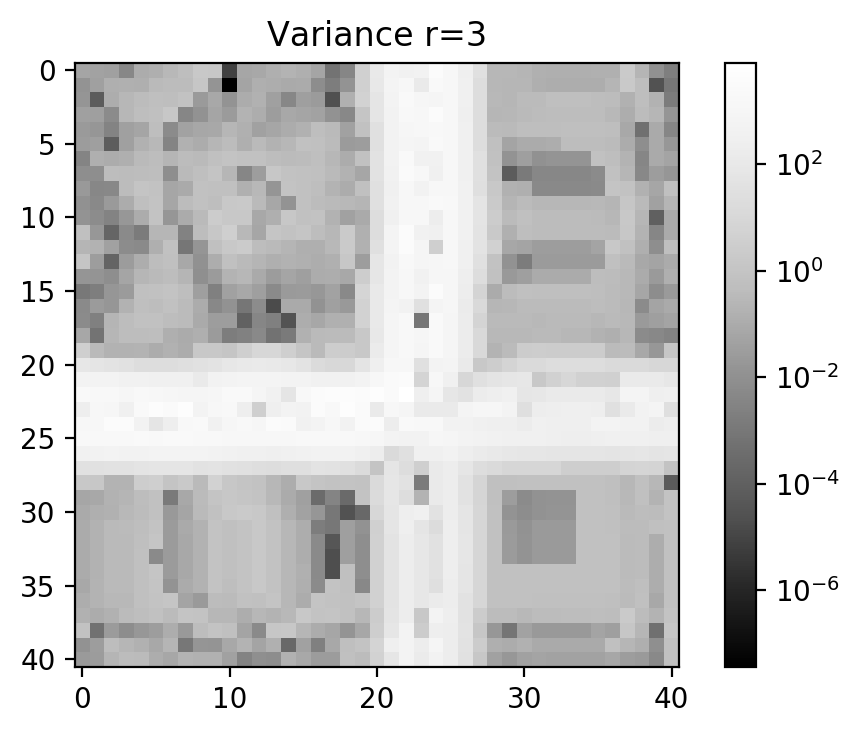

In [31]:
mean_images = []
max_radius = 5

image = (all_weighted_counts - np.min(all_weighted_counts)) / (np.max(all_weighted_counts) - np.min(all_weighted_counts))

for i in range(1, max_radius):
    mean_images.append(filters.rank.mean(image, selem=morphology.disk(i)))
    show_image(mean_images[-1])
    plt.gca().set_title("Mean r={}".format(i))
    
image = 255*image
variance_images = []
for i, mean_image in enumerate(mean_images):
    variance_images.append(np.power(image-mean_image,2))
    show_image(variance_images[-1])
    plt.gca().set_title("Variance r={}".format(i))
    

In [32]:
ps = []
fields = []
for i in range(uncertain_realizations.shape[2]):
    field, p = assignments(uncertain_realizations[:,:,i])
    ps.append(p)
    fields.append(field)
    
ps = np.array(ps)
fields = np.array(fields)
print(np.min(ps), np.max(ps), np.mean(ps), np.std(ps))

30.8503 36.8724 34.307462 1.3117328035678608


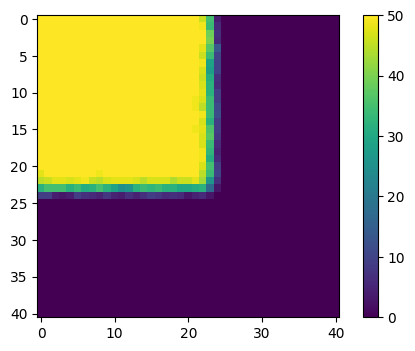

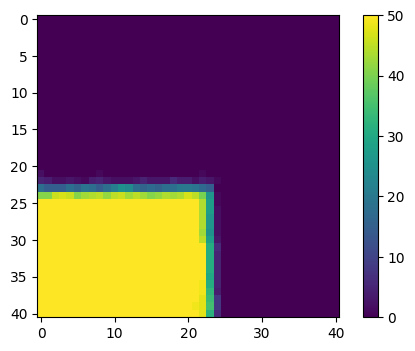

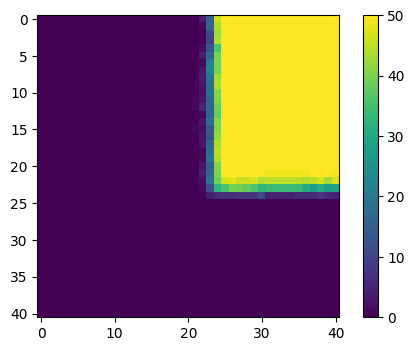

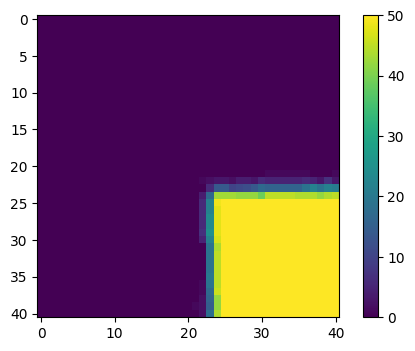

In [33]:
shape = (4,) + fields[0].shape
label_images = np.zeros(shape)
for i in range(4):
    test_image = (fields == i)
    label_images[i] = np.sum(test_image, axis=0)
    plt.figure(dpi=100)
    img = plt.imshow(label_images[i])
    plt.colorbar(img)

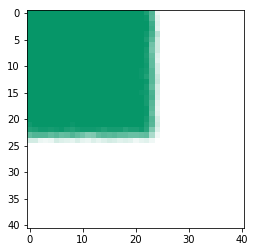

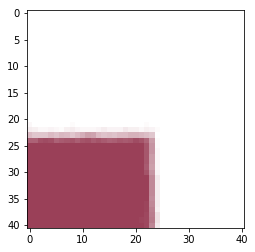

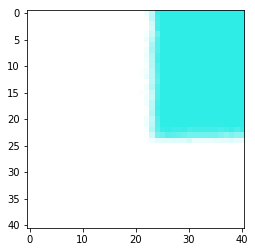

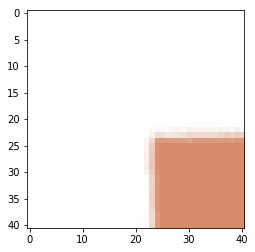

In [34]:
red_image = np.zeros(label_images[0].shape + (4,))
["rgb(6,150,104)", "rgb(154,64,88)", "rgb(46,236,230)", "rgb(215,139,105)"]
red_image[:,:,0] = 6./255.
red_image[:,:,1] = 150./255.
red_image[:,:,2] = 104./255.
green_image = np.zeros(label_images[0].shape + (4,))
green_image[:,:, 0] = 154./255.
green_image[:,:, 1] = 64./255.
green_image[:,:, 2] = 88./255.
blue_image = np.zeros(label_images[0].shape + (4,))
blue_image[:,:, 0] = 46./255
blue_image[:,:, 1] = 236./255
blue_image[:,:, 2] = 230./255
cyan_image = np.zeros(label_images[0].shape + (4,))
cyan_image[:,:, 0] = 215/255.
cyan_image[:,:, 1] = 139/255.
cyan_image[:,:, 2] = 105/255.

for i, label_image in enumerate(label_images):
    if i == 0:
        red_image[:,:, 3] = label_image / 50.
    elif i == 1:
        green_image[:,:, 3] = label_image / 50.
    elif i == 2:
        blue_image[:,:, 3] = label_image / 50.
    else:
        cyan_image[:,:, 3] = label_image / 50.

plt.figure()
plt.imshow(red_image)
plt.figure()
plt.imshow(green_image)
plt.figure()
plt.imshow(blue_image)
plt.figure()
plt.imshow(cyan_image)

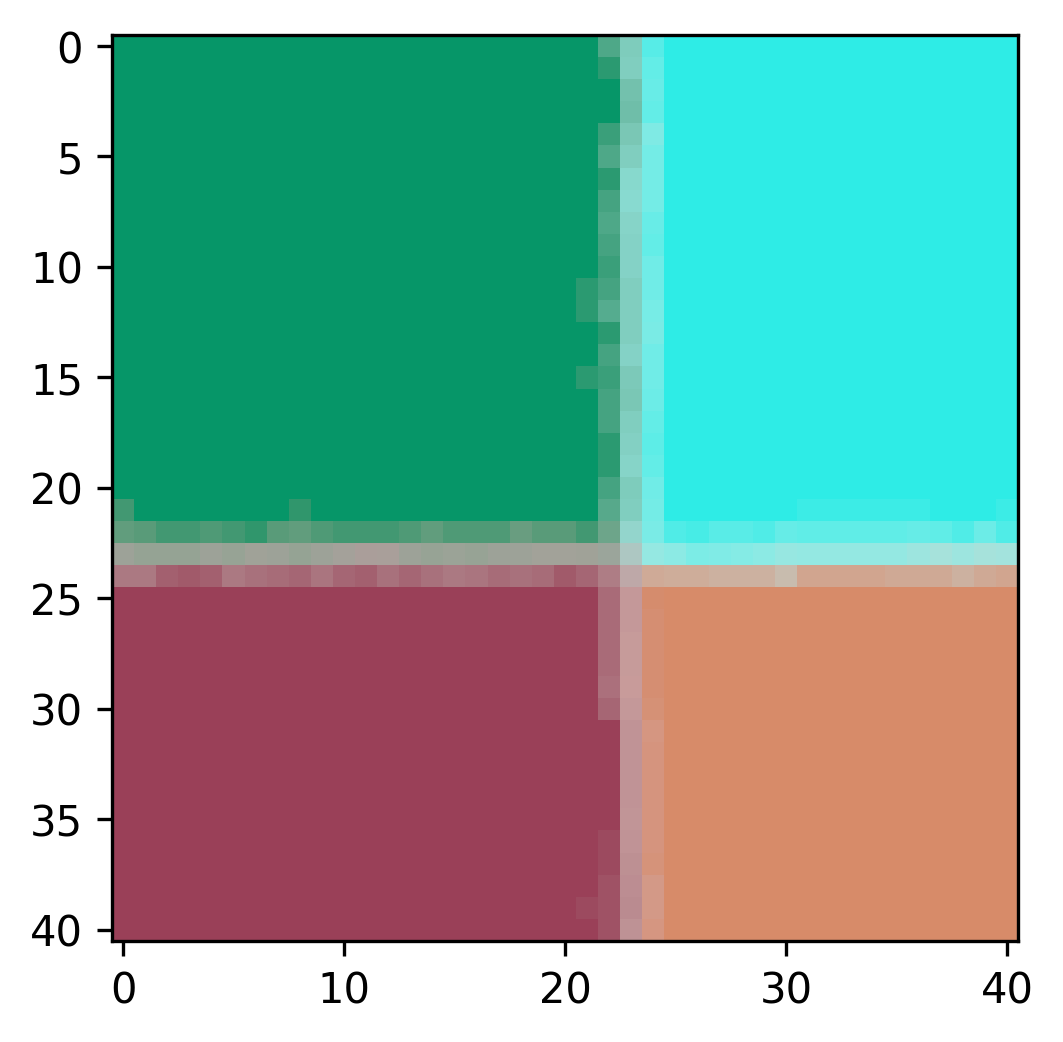

In [35]:
composite_image = overlay_alpha_image_precise(255*np.ones(red_image.shape)[:,:,:-1], 255*red_image, 1.)
composite_image = overlay_alpha_image_precise(composite_image, 255*cyan_image, 1)
composite_image = overlay_alpha_image_precise(composite_image, 255*green_image, 1)
composite_image = overlay_alpha_image_precise(composite_image, 255*blue_image, 1)
plt.figure(dpi=300)
plt.imshow(composite_image)

32.36889600753784


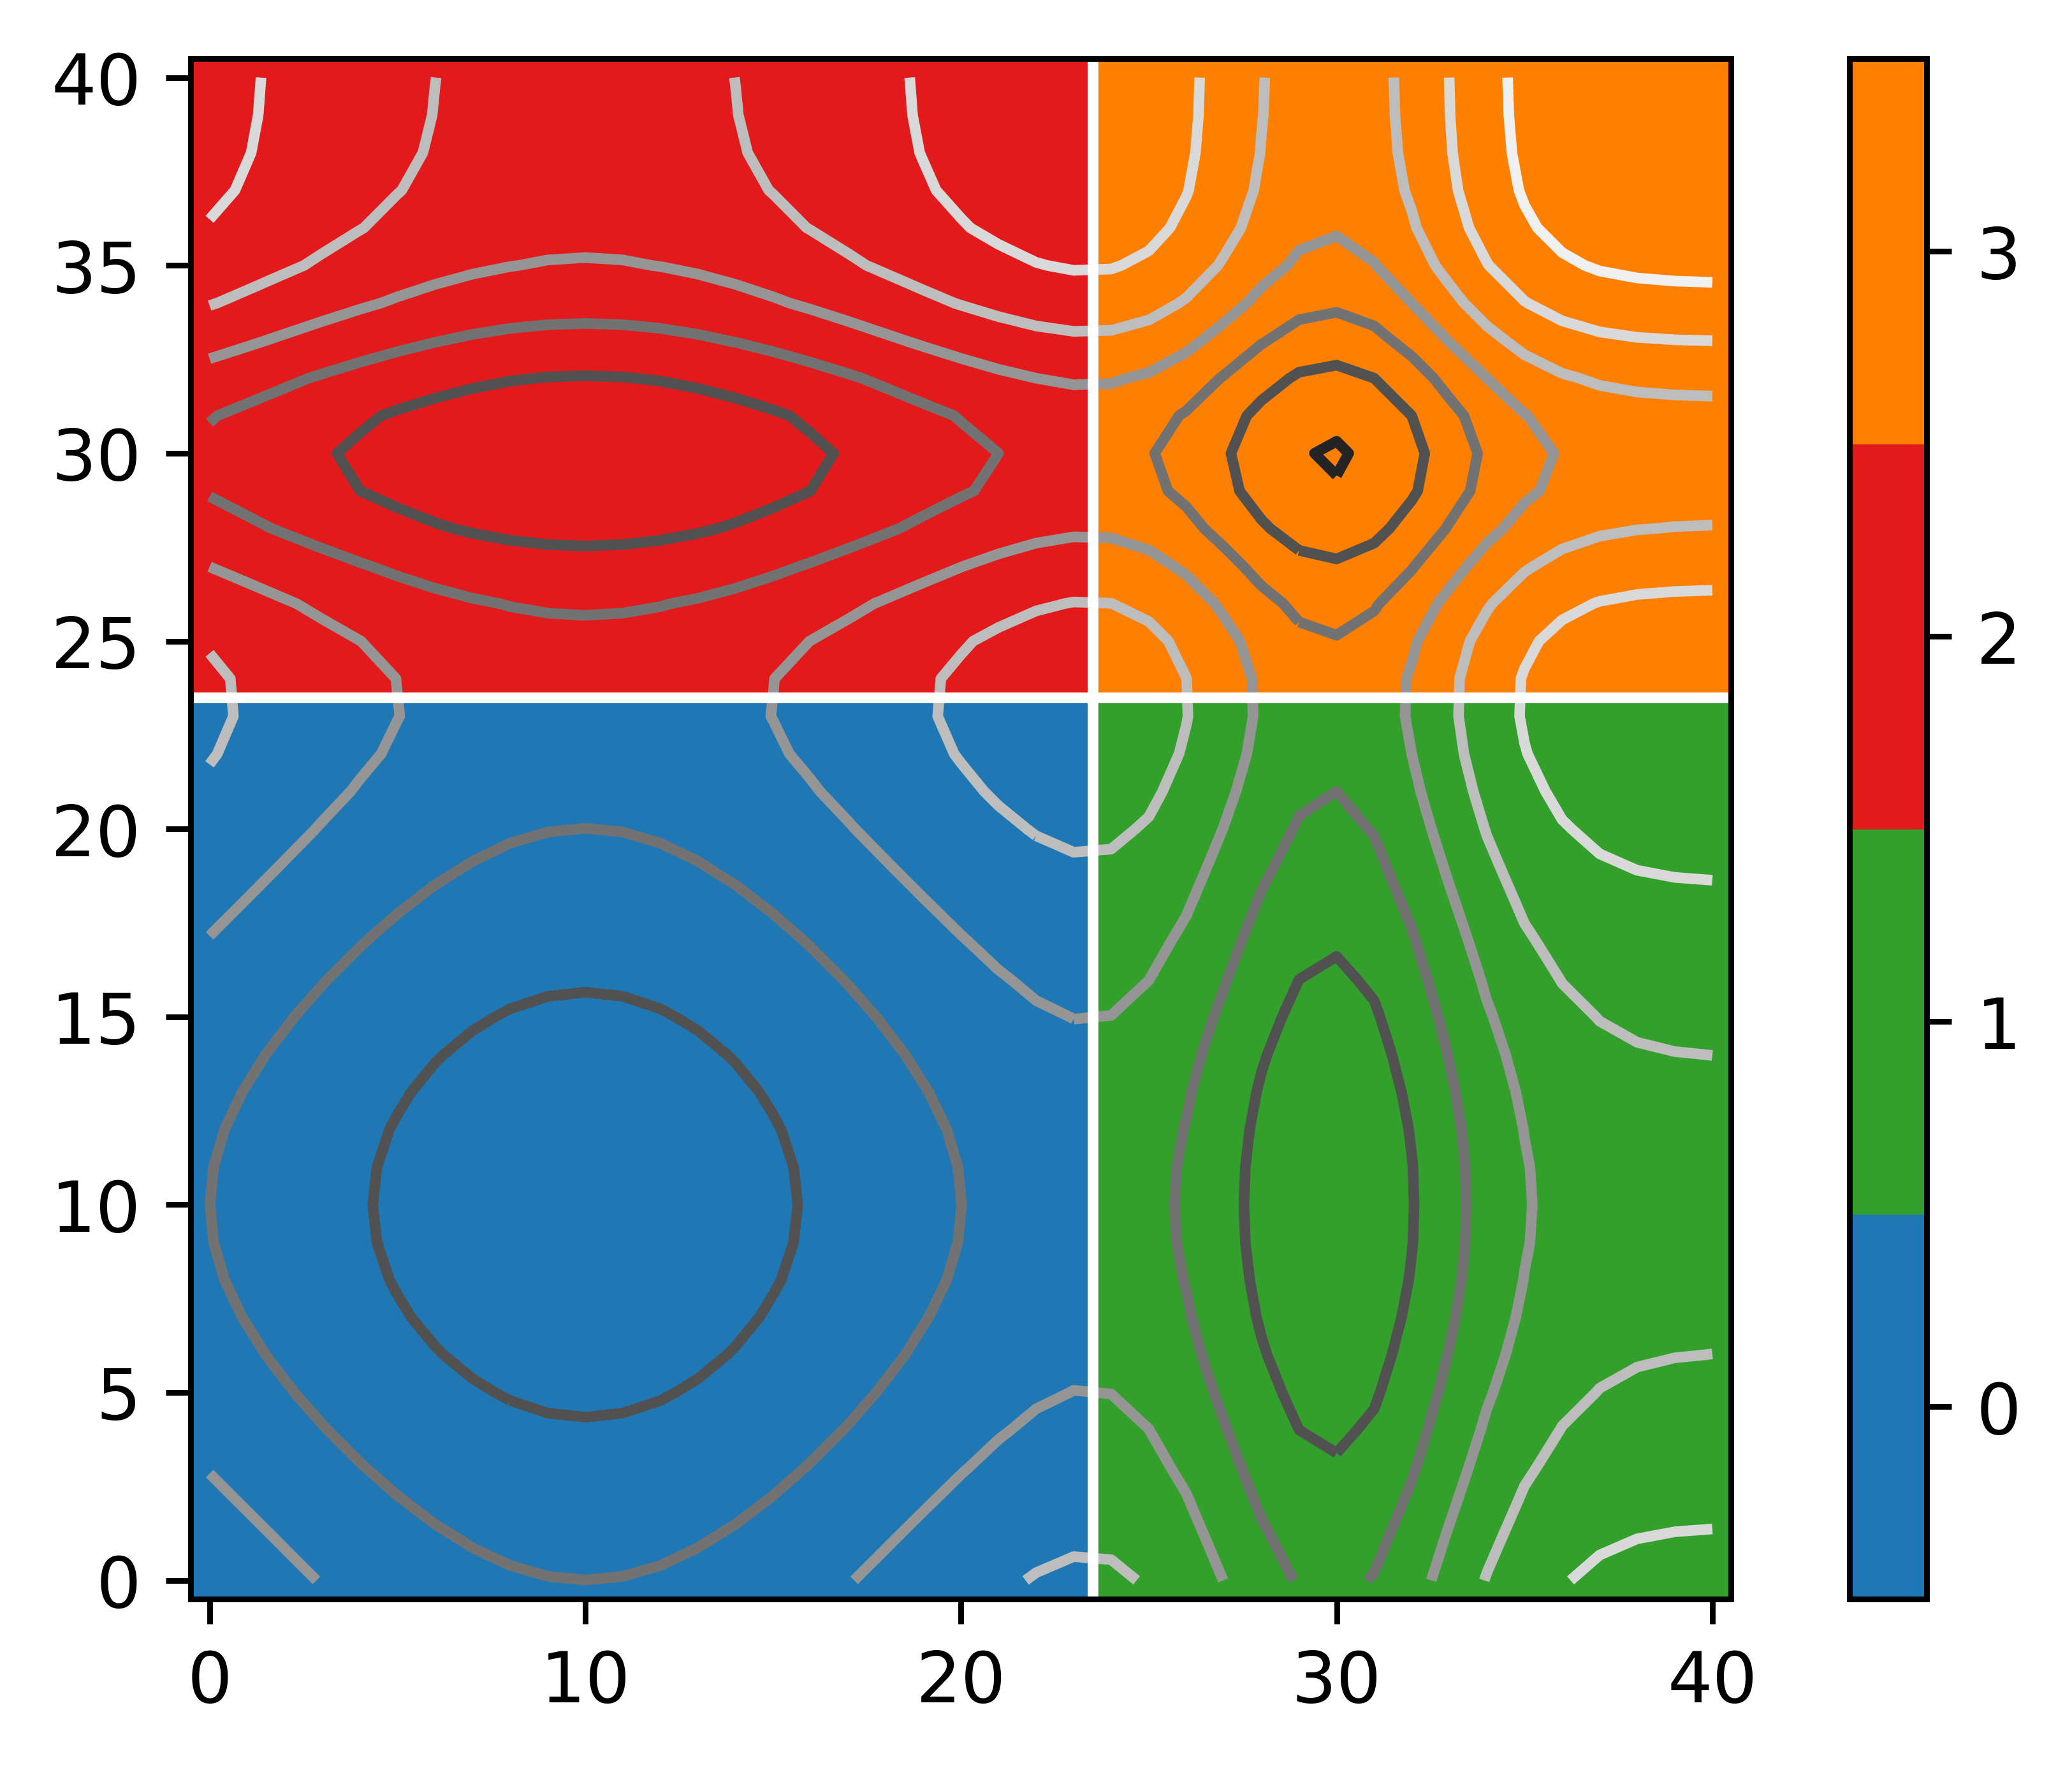

In [36]:
start = time.time()
plot_realization(ground_truth)
ax = plt.gca()
ax.axvline(23.5, 0, 41, c="#ffffff")
ax.axhline(23.5, 0, 41, c="#ffffff")
end = time.time()
print(end-start)

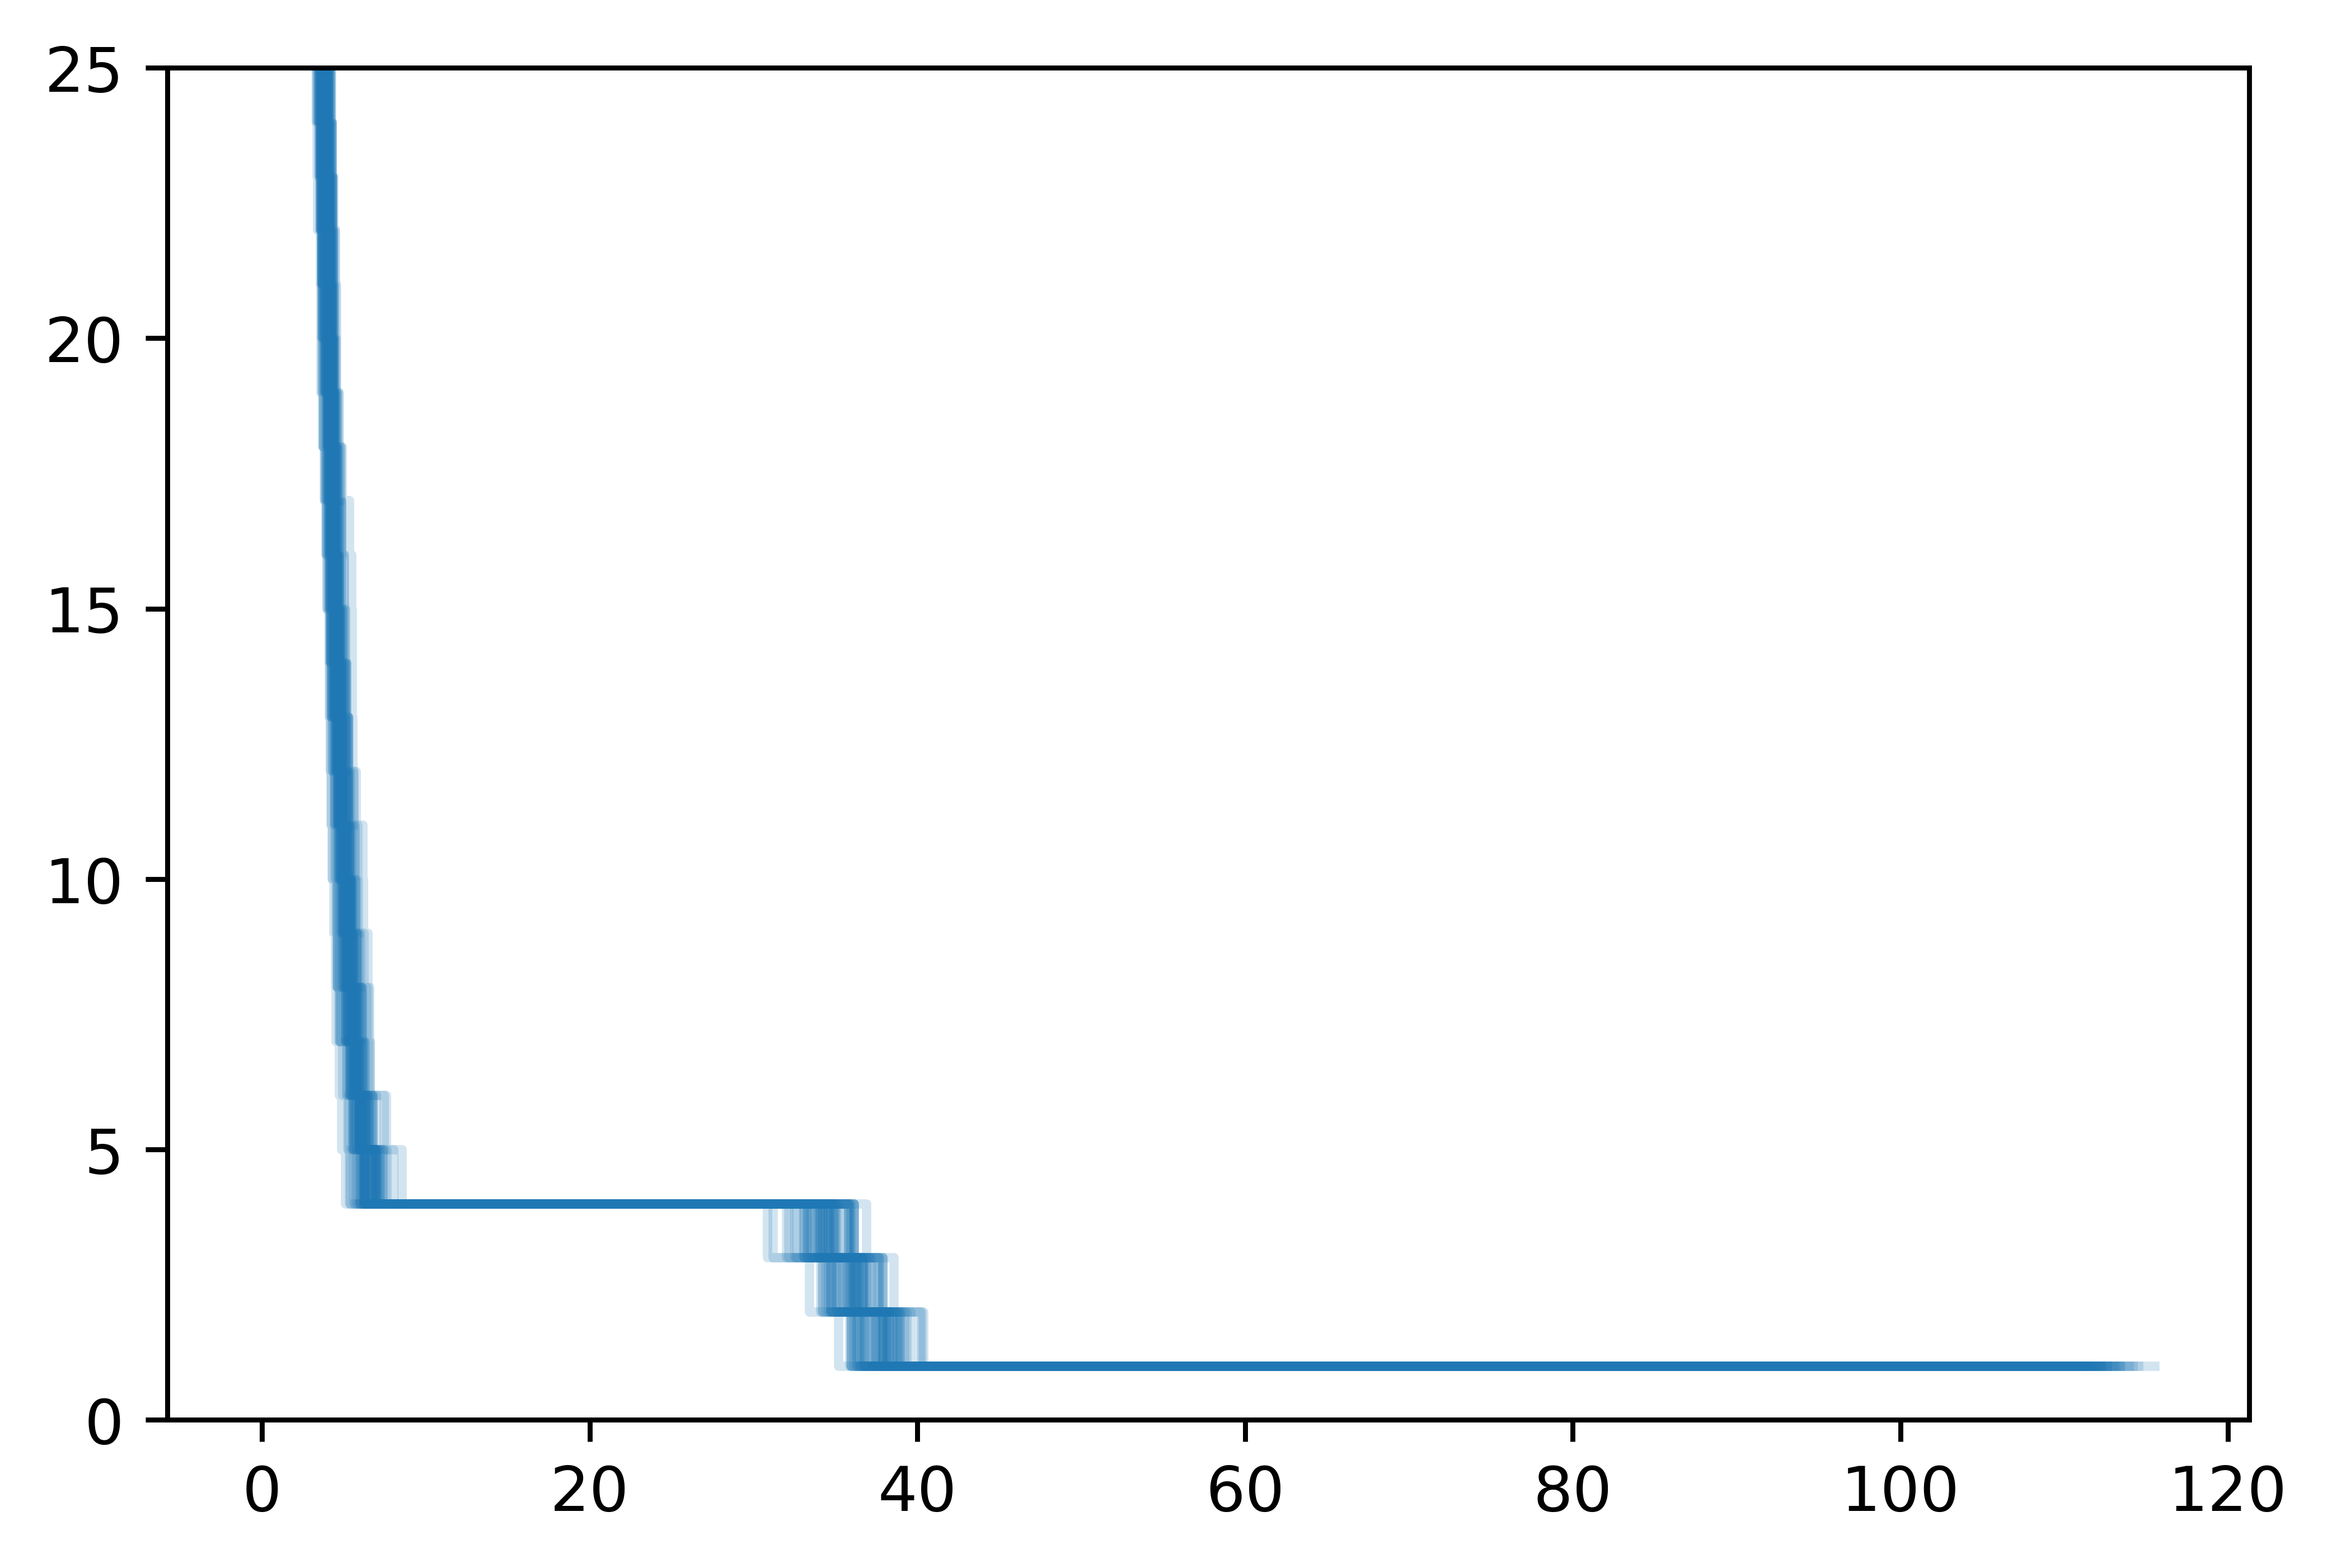

In [45]:
plt.figure(dpi=800)

all_ps = []
all_counts = []
for i in range(uncertain_realizations.shape[2]):
    tmc = topopy.MorseComplex(graph='beta skeleton',
                              gradient='steepest',
                              normalization='feature',
                              max_neighbors=10,
                              connect=True)

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)
    ps = [0]

    count = len(np.unique(list(tmc.get_partitions(0).keys())))
    counts = [count]
    eps = 1e-6
    for i, p in enumerate(tmc.persistences):
        ps.append(p)
        counts.append(count)
        count = len(np.unique(list(tmc.get_partitions(p+eps).keys())))
        ps.append(p)
        counts.append(count)

    all_ps.append(ps)
    all_counts.append(counts)
    plt.plot(ps, counts, alpha=0.2, c='#1f78b4')

ax = plt.gca()
ax.set_ylim(0, 25)
# plt.axhline(2, 0.10, 0.20, linestyle='dashed', color='#000000')
plt.show()

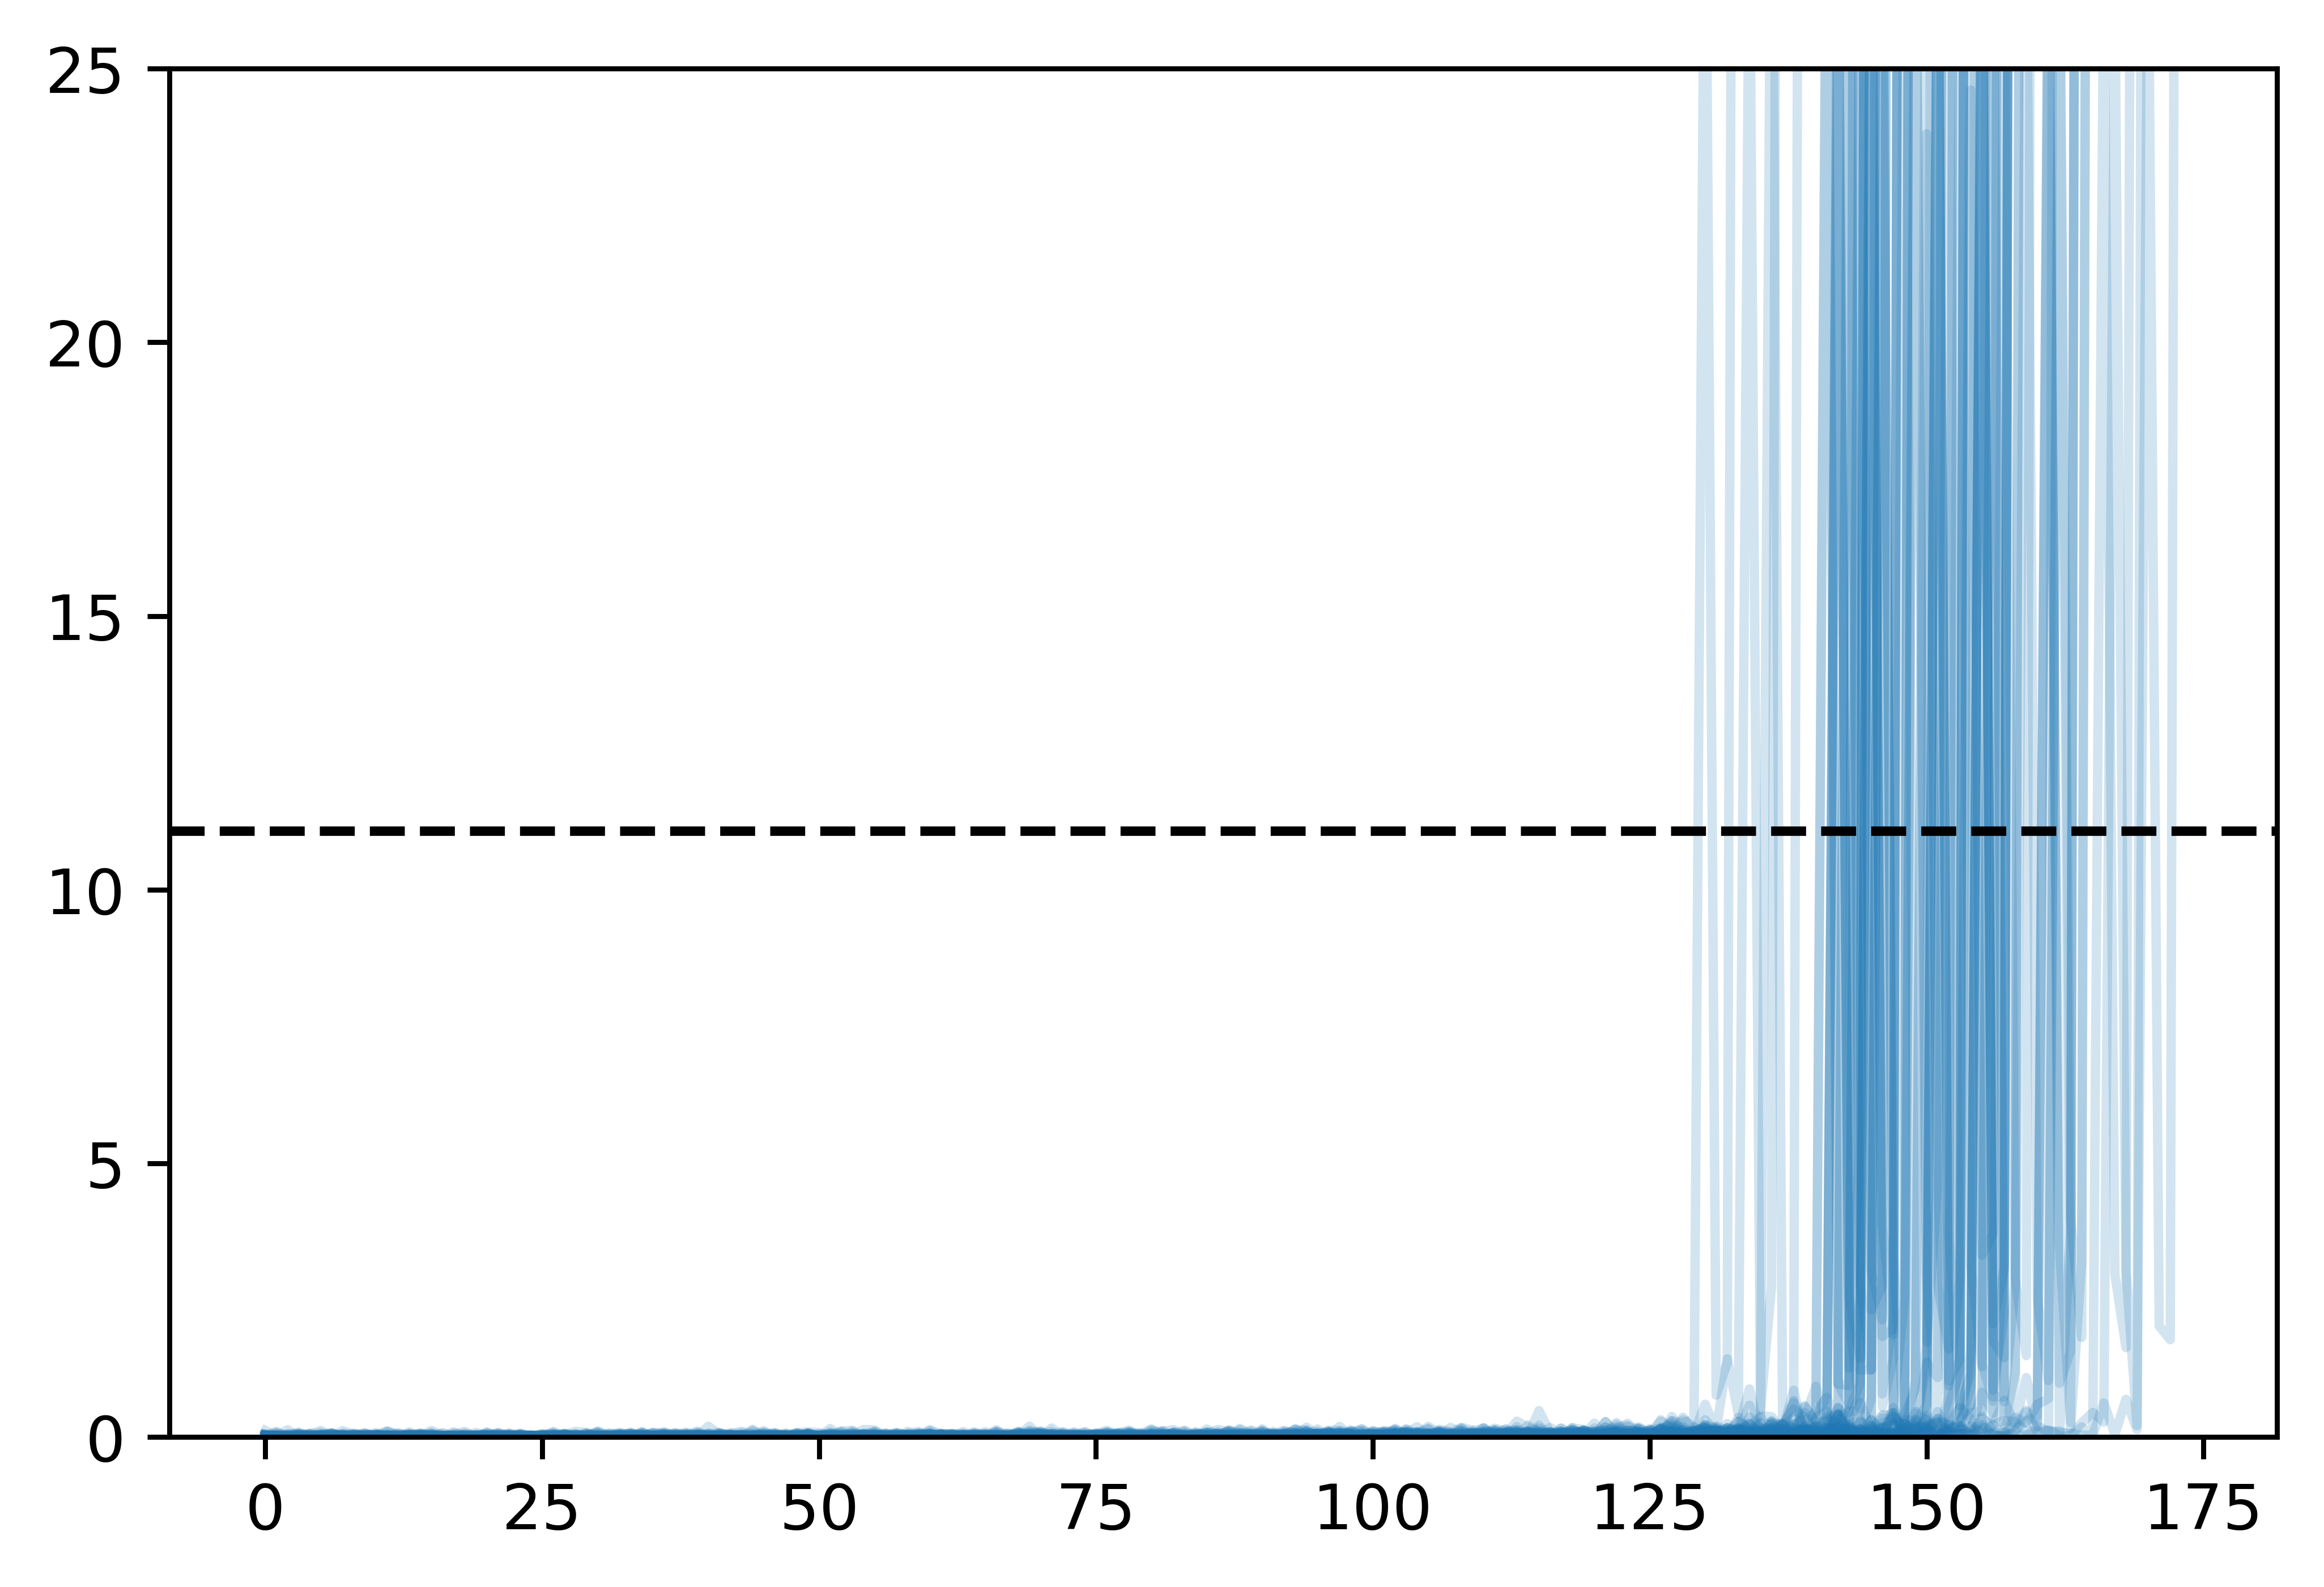

In [44]:
plt.figure(dpi=800)

for i in range(uncertain_realizations.shape[2]):
    tmc = topopy.MorseComplex(graph='beta skeleton',
                              gradient='steepest',
                              normalization='feature',
                              max_neighbors=10,
                              connect=True)

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)
    ps = [0]
    eps = 1e-6
    delta_ps = []
    for i, p in enumerate(tmc.persistences):
        if i > 0:
            delta_ps.append(p - tmc.persistences[i-1])
    plt.plot(delta_ps, alpha=0.2, c='#1f78b4')

plt.axhline(0.10*(np.max(Y)-np.min(Y)), 0, np.max(Y), linestyle='dashed', color='#000000')
ax = plt.gca()
ax.set_ylim(0, 25)
plt.show()

TypeError: unhashable type: 'list'

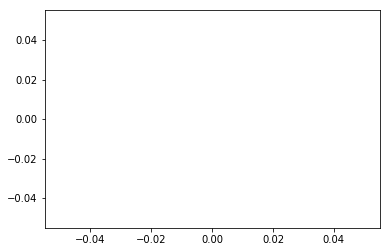

In [47]:
sns.lineplot(x=all_ps, y=all_counts)